# Project Based - Image Classifier

**DOMAIN**: Botanical research

**CONTEXT**: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at various stages of growth. They already have have invested on curating sample images. They require an automation which can create a classifier capable of determining a plant's species from a photo.

**DATA DESCRIPTION**: The dataset comprises of images from **12 plant species**. [Source](https://www.kaggle.com/c/plant-seedlings-classification/data)

**PROJECT OBJECTIVE**: University’s management require an automation which can create a classifier capable of determining a plant's species from a photo.

## Import the necessary libraries

In [2]:
import numpy as np # mathematical manipulations
import pandas as pd # data manipulations

# for visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# splitting into train and test sets and searching for hyperparameter tuning
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV

# pre-processing modules
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.decomposition import PCA # reduction technique

# ML model libraries
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# various model performance measures
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score,precision_recall_fscore_support

# Neural Network libraries
import tensorflow as tf

# unzipping the data
import zipfile

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# initialize random number generator
import random
# set the seed for consistent results for multiple runs
seed = 7
np.random.seed(seed)

## Importing the data

In [4]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# setting the base path
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projects/'

In [6]:
# list all the contents
!ls -lht '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projects/'

total 1.7G
-rw------- 1 root root 1.9M Feb 22 08:00  CNN_TRANSFER_LEARNING_PROJECT.ipynb
-rw------- 1 root root 1.7G Feb 20 04:47  train-20220219T112337Z-001.zip
-rw------- 1 root root 483K Feb 20 04:45 'Seedling - Prediction-20220219T112354Z-001.zip'


In [7]:
# loading the zipfile and extracting train data
with zipfile.ZipFile(BASE_PATH+'train-20220219T112337Z-001.zip','r') as zip_ref:
  zip_ref.extractall(path=BASE_PATH)

In [8]:
# verifying the training data structure
!ls -l "/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projects"

total 1686727
-rw-------  1 root root    1943609 Feb 22 08:01  CNN_TRANSFER_LEARNING_PROJECT.ipynb
-rw-------  1 root root     494005 Feb 20 04:45 'Seedling - Prediction-20220219T112354Z-001.zip'
drwx------ 14 root root       4096 Feb 22 08:01  train
-rw-------  1 root root 1724765924 Feb 20 04:47  train-20220219T112337Z-001.zip


In [8]:
# checking one of the folders
!ls -l "/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projects/train/Charlock" | head -6

total 154568
-rw------- 1 root root  319869 Feb 21 19:42 022179d65.png
-rw------- 1 root root   37877 Feb 21 19:42 02c95e601.png
-rw------- 1 root root 1578802 Feb 21 19:42 04098447d.png
-rw------- 1 root root  555763 Feb 21 19:42 04142acb9.png
-rw------- 1 root root  976213 Feb 21 19:42 0537577cd.png


In [9]:
# initialising a dataframe to hold all the values
plant_df = pd.DataFrame(columns=['IMAGE_PATH','IMAGE_CLASS'])

# setting up the dataframe to hold image path and class
for key in zip_ref.NameToInfo.keys():
  img_path = BASE_PATH + key
  img_class = key.split('/')[1]
  plant_df.loc[plant_df.shape[0]] = [img_path, img_class]
zip_ref.close()

In [10]:
# checking top 5 records
plant_df.head()

IMAGE_PATH        IMAGE_CLASS
0  /content/drive/MyDrive/Colab Notebooks/Deep Le...        Black-grass
1  /content/drive/MyDrive/Colab Notebooks/Deep Le...  Scentless Mayweed
2  /content/drive/MyDrive/Colab Notebooks/Deep Le...  Scentless Mayweed
3  /content/drive/MyDrive/Colab Notebooks/Deep Le...  Scentless Mayweed
4  /content/drive/MyDrive/Colab Notebooks/Deep Le...  Scentless Mayweed

In [11]:
# analysing shape of dataframe
plant_df.shape

(4767, 2)

In [12]:
# get the plant classes
classes = plant_df['IMAGE_CLASS'].unique()
number_of_classes = len(classes)
print(number_of_classes)

12


### Observations:
- We have training and validation data in the form of structured folders with folder names as the class names.
- We have **12** unique plant classes.
- We have **4767** images for training and validation.

## Visualisation

In [13]:
# the image parameters we would use for resize
IMG_HEIGHT = 224
IMG_WIDTH = 224

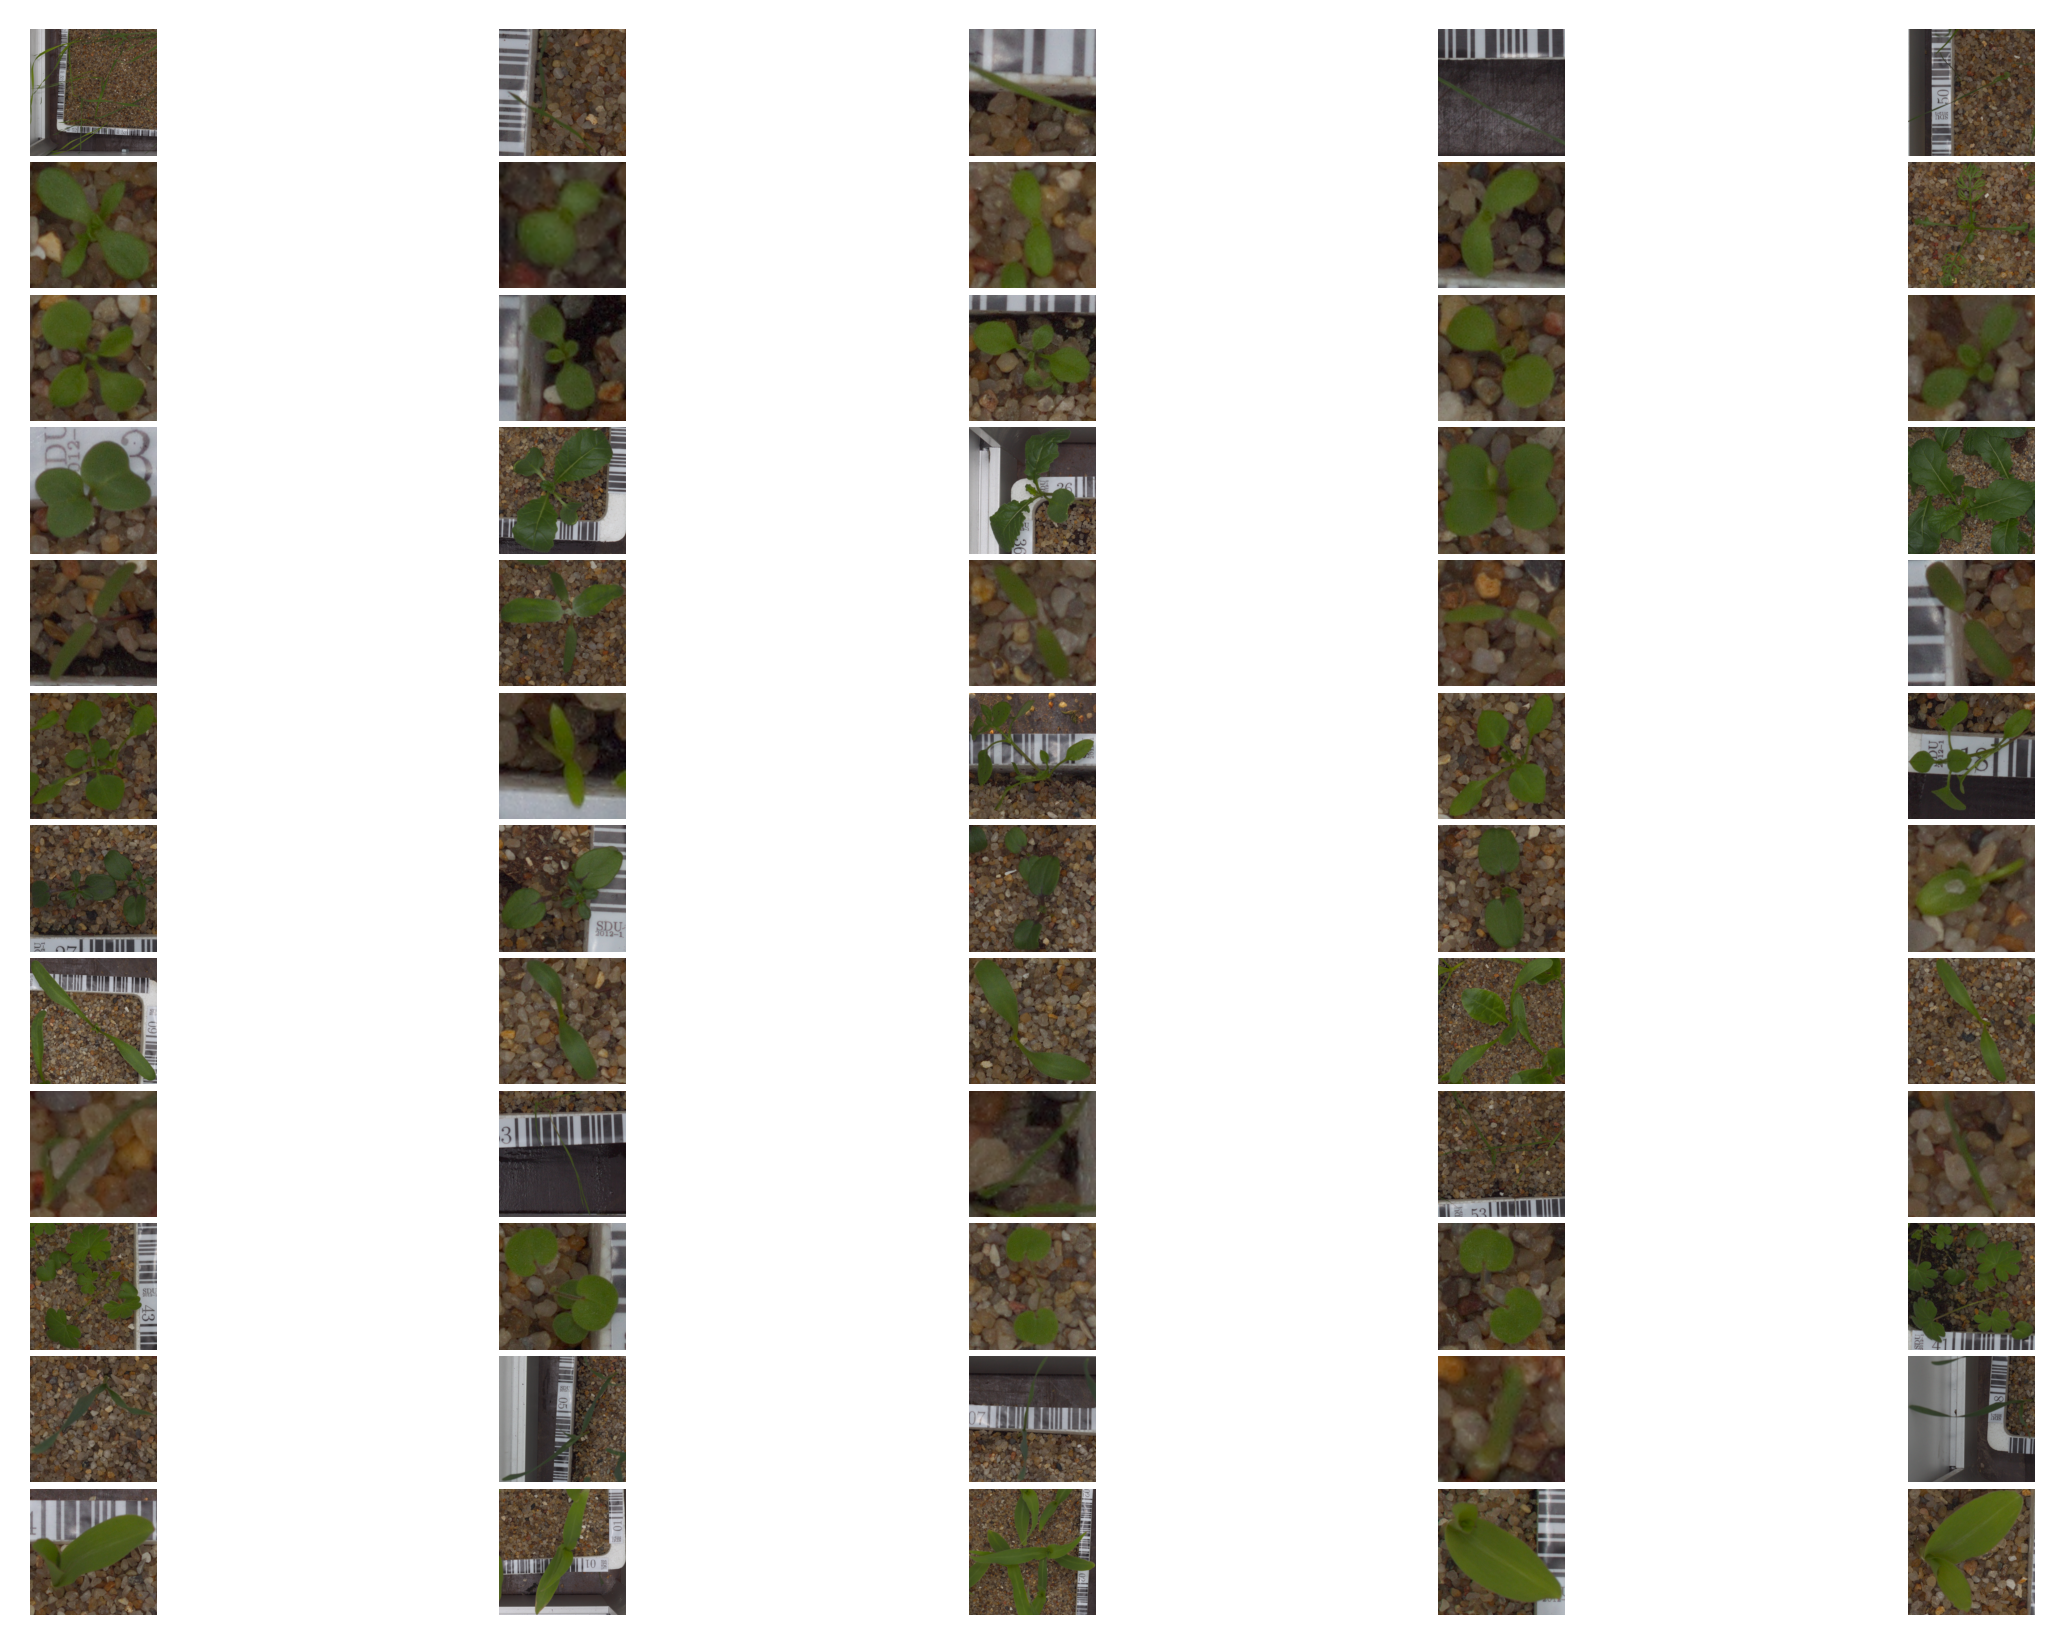

In [15]:
# images don't get rendered in .html, please se .ipynb
# visualising randomly the images of different classes
figure,ax = plt.subplots(number_of_classes,5,gridspec_kw={'height_ratios': [1]*number_of_classes,'wspace':0.05, 'hspace':0.05})

# setting figure parameters
figure.set_figheight(7)
figure.set_figwidth(10)
figure.set_dpi(300)

for idx,plant_class in enumerate(classes):
  class_df = plant_df[plant_df['IMAGE_CLASS'] == plant_class]
  for i in range(0,5):
    rand_idx = np.random.randint(low=0,high=class_df.shape[0])
    img_path = class_df.iloc[rand_idx]['IMAGE_PATH']
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_arr = tf.keras.preprocessing.image.img_to_array(img.resize([IMG_WIDTH,IMG_HEIGHT]))
    ax[idx][i].axis('off')
    ax[idx][i].set_aspect('equal')
    ax[idx][i].imshow(img_arr.astype('uint8'))     
plt.tight_layout()
plt.show()

In [ ]:
# plotting the number of smaples of each class
# initialising subplots
figure, ax = plt.subplots(nrows=1, ncols=2)

# setting figure parameters
figure.set_figheight(7)
figure.set_figwidth(25)

#setting axes titles
ax[0].set_title(f'Pie Chart of Image Classes')
ax[1].set_title(f'Count plot of Image Classes')

# plotting the distribution
plant_df['IMAGE_CLASS'].value_counts().plot.pie(ax=ax[0],autopct='%1.1f%%')
sns.countplot(x='IMAGE_CLASS',data=plant_df,ax=ax[1])

plt.tight_layout()
plt.show()

In [ ]:
# getting image sizes randomly
for plant_class in classes:
  class_df = plant_df[plant_df['IMAGE_CLASS'] == plant_class]
  print(f'Size of Images in {plant_class.upper()}')
  size_list = []
  for i in range(0,5):
    rand_idx = np.random.randint(low=0,high=class_df.shape[0])
    img_path = class_df.iloc[rand_idx]['IMAGE_PATH']
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    size_list.append(img_arr.shape)
  print(size_list)
  print()

Size of Images in BLACK-GRASS
[(92, 92, 3), (100, 100, 3), (1435, 1435, 3), (167, 167, 3), (531, 531, 3)]

Size of Images in SCENTLESS MAYWEED
[(53, 53, 3), (105, 105, 3), (155, 155, 3), (149, 149, 3), (117, 117, 3)]

Size of Images in SHEPHERDS PURSE
[(108, 108, 3), (96, 96, 3), (361, 361, 3), (96, 96, 3), (118, 118, 3)]

Size of Images in CHARLOCK
[(166, 166, 3), (471, 471, 3), (469, 469, 3), (381, 381, 3), (204, 204, 3)]

Size of Images in FAT HEN
[(253, 253, 3), (278, 278, 3), (108, 108, 3), (180, 180, 3), (311, 311, 3)]

Size of Images in COMMON CHICKWEED
[(198, 198, 3), (536, 536, 3), (75, 75, 3), (155, 155, 3), (517, 517, 3)]

Size of Images in CLEAVERS
[(275, 275, 3), (159, 159, 3), (276, 276, 3), (507, 507, 3), (329, 329, 3)]

Size of Images in SUGAR BEET
[(448, 448, 3), (1207, 1207, 3), (1715, 1715, 3), (611, 611, 3), (536, 536, 3)]

Size of Images in LOOSE SILKY-BENT
[(195, 195, 3), (139, 139, 3), (173, 173, 3), (196, 196, 3), (180, 180, 3)]

Size of Images in SMALL-FLOWERED

### Observations:
- From the *grid-plot* we could see the images of each of the plant species.
- Those images have a lot of background captured.
- The number of images for each plant species is **imbalanced**, so for *supervised-learning classification* we might want to use *over-sampling* techniques and for *deep networks* we will resort to *data-augumentation*.
- The images are colour images as seen in **3 RGB** channels.
- The images are of varying *sizes*, so we will have to resort to *re-sizing* techniques for uniformity.

## Reading and pre-processing the images

- For the *traditional* supervised-learning techniques we will make use *Tensorflow Image* module to read and res-size images.
- For *neural networks* we will make use of *Tensorflow Image Data Generator* module.

In [14]:
# split data into train and test in 80:20 ratio
train_df, test_df = train_test_split(plant_df, test_size=0.2, random_state=seed)

In [15]:
# shape of training data frame
train_df.reset_index(inplace=True)
train_df.shape

(3813, 3)

In [16]:
# shape of test data frame
test_df.reset_index(inplace=True)
test_df.shape

(954, 3)

In [17]:
# reading and resizing images for supervised learning approaches
def read_resize_img(df,dtype):
  '''
  this method reads the images from a specified data frame
  and returns the numpy array of the image as specified datatype.
  Also gives the corresponding class labels.
  '''
  supervised_img_arr = []
  class_labels = []
  for idx in range(0,df.shape[0]):
    img_path = df.loc[idx]['IMAGE_PATH']
    img = tf.keras.preprocessing.image.load_img(img_path)
    img_arr = tf.keras.preprocessing.image.img_to_array(img.resize([IMG_WIDTH,IMG_HEIGHT]))
    supervised_img_arr.append(img_arr.astype(dtype))

    img_class = df.loc[idx]['IMAGE_CLASS']
    class_labels.append(img_class)
  return np.array(supervised_img_arr), np.array(class_labels)

In [18]:
train_img_arr, train_labels = read_resize_img(train_df,'uint8')
test_img_arr, test_labels = read_resize_img(test_df,'uint8')

In [19]:
train_img_arr.shape

(3813, 224, 224, 3)

In [20]:
train_labels.shape

(3813,)

In [21]:
test_img_arr.shape

(954, 224, 224, 3)

In [22]:
test_labels.shape

(954,)

### Observations:
- **Training data** contains **3813** samples.
- **Testing data** contains **954** labels.
- Size of each train and test image is **1x224x224x3**.
- We will use an **Image Data Generator** for neural networks.

## Machine Learning Classifiers
We would be developing classifiers based on:
- **Traditional Supervised Learning Algorithms**
- **Traditional Neural Networks**
- **Convolutional Neural Networks**

### Traditional Supervised Learning Algorithms
We will creating a backup copy of the original data, so that we can easily manipulate the data.

In [21]:
# copying the original data
X_train_copy = train_img_arr.copy()
y_train_copy = train_labels.copy()

X_test_copy = test_img_arr.copy()
y_test_copy = test_labels.copy()

In [22]:
# One Hot encoding of labelled classes
label_encoder = LabelEncoder() # object of label encoder

y_train_enc = label_encoder.fit_transform(y_train_copy) # transforming the data
y_test_enc = label_encoder.fit_transform(y_test_copy) # transforming the data

In [27]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred,labels=[i for i in range(0,12)]) # getting the confusion matrix
    
    cm_df = pd.DataFrame(cm, index=[i for i in range(0,12)], columns=[i for i in range(0,12)]) # confusion matrix data frame
    
    plt.figure(figsize=(10,10))
    sns.heatmap(cm_df,annot=True,fmt='g') # plotting the heatmap
    plt.show()

In [28]:
def calculate_performance_measures(y_test,y_pred,model):
    prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, average = 'macro')
    print('Precision Score :', '%0.2f' % prec)
    print('Recall Score :', '%0.2f' % rec)
    print('F1-Score:', '%0.2f' % f1)
    acc= accuracy_score(y_test, y_pred)
    print('Accuracy Score :','%0.2f' % acc)
    model_lists.append([model, acc * 100, rec * 100, prec * 100,f1*100])

In [29]:
def evaluate_the_model(model,model_name,X_train,y_train,X_test,y_test):
  # predict on test data
  y_pred = model.predict(X_test)
  predictions[model_name] = y_pred

  train_accuracy = model.score(X_train,y_train)
  test_accuracy = model.score(X_test,y_test)
  accuracies[model_name] = [train_accuracy,test_accuracy]

  print(f'The accuracy score of model on train data is {round(train_accuracy,4)*100}%')
  print(f'The accuracy score of model on test data is {round(test_accuracy,4)*100}%')
  print()
  print('The classification report is::')
  print(classification_report(y_test,y_pred))

  plot_confusion_matrix(y_test,y_pred)

  calculate_performance_measures(y_test,y_pred,model_name)

In [ ]:
# initialised a dictionary to hold accuracy of various models
# {model: [train_accuracy,test_accuracy]}
accuracies = {}

In [ ]:
# initialised a dictionary to hold predictions of various models
# {model: [predictions]}
predictions = {}

In [ ]:
model_lists = [] # initialise to hold various model parameters

In [ ]:
import cv2
# applying PCA to reduce dimensions
def flatten(X):
  '''
  This returns the flattened R, G, B channels of the array
  '''
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return Xr, Xg, Xb

# flattening the channels
X_train_r, X_train_g, X_train_b = flatten(X_train_copy)
X_test_r, X_test_g, X_test_b = flatten(X_test_copy)

# reducing the features
n_components = 500
X_train_pca_r = PCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_pca_g = PCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_pca_b = PCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_pca_r = PCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_pca_g = PCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_pca_b = PCA(n_components=n_components, whiten=True).fit(X_test_b)

# checking the variance explained
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum()

(0.9641836454292114, 0.9584661940666951, 0.9707828871140157)

In [ ]:
# transforming the variables
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)

#### Support Vector Machine(SVM) with GridSearchCV

In [ ]:
# hyper-parameters to search from
param_grid = {'C': [0.1,1], 'gamma': [0.01,0.001],'kernel': ['rbf', 'poly']}

# grid search classifier
svm_grid= GridSearchCV(SVC(), param_grid, verbose = 2,cv=5, n_jobs = -1)
 
# # fit on samples
svm_grid.fit(X_train_pca, y_train_enc)

# getting the best parameters
svm_grid.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
# call to the function
evaluate_the_model(svm_grid,'SVM with Grid Search CV',X_train_pca,y_train_enc,X_test_pca,y_test_enc)

The accuracy score of model on train data is 89.82%
The accuracy score of model on test data is 16.77%

The classification report is::
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.00      0.00      0.00        71
           2       0.00      0.00      0.00        58
           3       0.16      0.15      0.15       124
           4       0.00      0.00      0.00        31
           5       0.00      0.00      0.00       120
           6       0.15      0.69      0.24       132
           7       0.00      0.00      0.00        38
           8       0.23      0.51      0.32        96
           9       0.00      0.00      0.00        43
          10       0.17      0.02      0.04       101
          11       0.00      0.00      0.00        80

    accuracy                           0.17       954
   macro avg       0.06      0.11      0.06       954
weighted avg       0.08      0.17      0.09       954

Precision Score : 0.06
Recall Score : 0.11
F1-Score: 0.06
Accuracy Score : 0.17


#### Decision Tree Classifier with GridSearchCV

In [ ]:
# hyper-parameters to search from
param_grid = [{'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}]

# grid search classifier
dt_grid= GridSearchCV(DecisionTreeClassifier(), param_grid, verbose = 2,cv=5, n_jobs = -1)
 
# fit on samples
dt_grid.fit(X_train_pca, y_train_enc)

# getting the best parameters
dt_grid.best_params_

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


{'max_leaf_nodes': 16, 'min_samples_split': 2}

In [ ]:
# call to the function
evaluate_the_model(dt_grid,'Decision Tree with Grid Search CV',X_train_pca,y_train_enc,X_test_pca,y_test_enc)

The accuracy score of model on train data is 29.770000000000003%
The accuracy score of model on test data is 13.420000000000002%

The classification report is::
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.29      0.24      0.26        71
           2       0.31      0.40      0.35        58
           3       0.20      0.26      0.23       124
           4       0.00      0.00      0.00        31
           5       0.00      0.00      0.00       120
           6       0.08      0.17      0.11       132
           7       0.00      0.00      0.00        38
           8       0.09      0.06      0.07        96
           9       0.00      0.00      0.00        43
          10       0.10      0.26      0.14       101
          11       0.04      0.01      0.02        80

    accuracy                           0.13       954
   macro avg       0.09      0.12      0.10       954
weighted avg       0.10    

Precision Score : 0.09
Recall Score : 0.12
F1-Score: 0.10
Accuracy Score : 0.13


#### Random Forest with Grid Search CV

In [ ]:
# hyper-parameters to search from
param_grid=[{'n_estimators':[100],'min_samples_leaf':[2,3]}]

# grid search classifier
rf_grid= GridSearchCV(RandomForestClassifier(), param_grid, verbose = 2,cv=5, n_jobs = -1)
 
# fit on over samples
rf_grid.fit(X_train_pca, y_train_enc)

# getting the best parameters
rf_grid.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'min_samples_leaf': 3, 'n_estimators': 100}

In [ ]:
# call to the function
evaluate_the_model(rf_grid,'Random Forest with Grid Search CV',X_train_pca,y_train_enc,X_test_pca,y_test_enc)

The accuracy score of model on train data is 100.0%
The accuracy score of model on test data is 20.86%

The classification report is::
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.17      0.08      0.11        71
           2       0.25      0.02      0.03        58
           3       0.27      0.48      0.34       124
           4       0.00      0.00      0.00        31
           5       0.11      0.03      0.05       120
           6       0.18      0.55      0.28       132
           7       0.00      0.00      0.00        38
           8       0.21      0.29      0.24        96
           9       0.00      0.00      0.00        43
          10       0.22      0.20      0.21       101
          11       0.21      0.10      0.14        80

    accuracy                           0.21       954
   macro avg       0.14      0.15      0.12       954
weighted avg       0.16      0.21      0.16       954

Precision Score : 0.14
Recall Score : 0.15
F1-Score: 0.12
Accuracy Score : 0.21


##### Algorithm Comparison

In [ ]:
model_df = pd.DataFrame(model_lists, columns = ['Model', 'Accuracy Scores on Test', 'Recall Score', 'Precision Score','F1 Score'])
model_df

Model  ...   F1 Score
0            SVM with Grid Search CV  ...   6.237525
1  Decision Tree with Grid Search CV  ...   9.780976
2  Random Forest with Grid Search CV  ...  11.686292

[3 rows x 5 columns]

In [ ]:
accuracy_df = pd.DataFrame(accuracies,index=['Train Accuracy','Test Accuracy'])
accuracy_df

SVM with Grid Search CV  ...  Random Forest with Grid Search CV
Train Accuracy                 0.898243  ...                           1.000000
Test Accuracy                  0.167715  ...                           0.208595

[2 rows x 3 columns]

##### Observations:
From above metrics, dataframes, confusion matrix, classification reports it can be observed:
- The models are performing really poor on the *testing* data.
- The models are clearly *over-fitting*.
- The *accuracies* are very very low.
- So we need to resort to other techniques like Neural Networks, Deep Neural Networks.

## Neural Network(NN)

In [23]:
BATCH_SIZE = 50 # used for passing data to neural networks

In [24]:
# Training data generator with augmentation
train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            horizontal_flip=True)

# Test data generator without augmentation
test_img_gen = tf.keras.preprocessing.image.ImageDataGenerator()

In [25]:
# flow from dataframe based on the generator
train_gen = train_img_gen.flow_from_dataframe(dataframe=train_df,
                                              x_col='IMAGE_PATH',
                                              y_col='IMAGE_CLASS',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              batch_size = BATCH_SIZE)

test_gen = test_img_gen.flow_from_dataframe(dataframe=test_df,
                                            x_col='IMAGE_PATH',
                                            y_col='IMAGE_CLASS',
                                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                                            batch_size = BATCH_SIZE)

Found 3813 validated image filenames belonging to 12 classes.
Found 954 validated image filenames belonging to 12 classes.


In [26]:
# how the train classes will be encoded
train_gen.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [26]:
# how the test classes will be encoded
test_gen.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [23]:
def get_predicted_class(pred):
  '''
  returns the name of the predicted class against the encoded version.
  '''
  for key,value in train_gen.class_indices.items():
    if value == pred:
      return key

In [28]:
train_size = len(train_gen.filenames)
test_size = len(test_gen.filenames)

In [29]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
# getting one-hot labels
y_train_labelled = enc.fit_transform(y_train_copy)

In [30]:
# getting one-hot labels
y_test_labelled = enc.fit_transform(y_test_copy)

In [24]:
def plot_train_history_with_epochs(training_history):
  '''
  This function is used to plot Training and Validation loss, accuracy
  versus the number of epochs based on the training history of the model.
  '''
  # extracting training and validation losses from model history
  train_loss = training_history.history['loss']
  val_loss = training_history.history['val_loss']
  
  # number of epochs
  epochs = range(len(train_loss))

  # plot train and validation loss w.r.t number of epochs
  plt.figure(figsize=(10,8))
  plt.plot(epochs, train_loss, label = 'training loss')
  plt.plot(epochs, val_loss, label = 'validation loss')
  plt.legend(loc='upper right')
  plt.xlabel('Number of Epochs')
  plt.ylabel('Training and Validation loss')
  plt.title('Training and Validation loss v/s Epochs')
  plt.show()

  # extracting training and validation accuracies and losses from model history
  train_accuracy = training_history.history['accuracy']
  val_accuracy = training_history.history['val_accuracy']

  # number of epochs
  epochs = range(len(train_accuracy))
  print()
  # plot train and validation accuracy w.r.t number of epochs
  plt.figure(figsize=(10,8))
  plt.plot(epochs, train_accuracy, label = 'training accuracy')
  plt.plot(epochs, val_accuracy, label = 'validation accuracy')
  plt.legend(loc='lower right')
  plt.xlabel('Number of Epochs')
  plt.ylabel('Training and Validation Accuracy')
  plt.title('Training and Validation Accuracy v/s Epochs')
  plt.show()

In [25]:
# loading the zipfile and extracting prediction data
with zipfile.ZipFile(BASE_PATH+'Seedling - Prediction-20220219T112354Z-001.zip','r') as zip_ref:
  zip_ref.extractall(path=BASE_PATH)

In [26]:
# verifying the prediction data structure
!ls -l "/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projects/Seedling - Prediction"

total 483
-rw------- 1 root root 493661 Feb 22 08:07 Predict.png


In [27]:
for key in zip_ref.NameToInfo.keys():
  img_path = BASE_PATH + key
  img = tf.keras.preprocessing.image.load_img(img_path)
  img_arr = tf.keras.preprocessing.image.img_to_array(img.resize([IMG_WIDTH,IMG_HEIGHT]))
zip_ref.close()

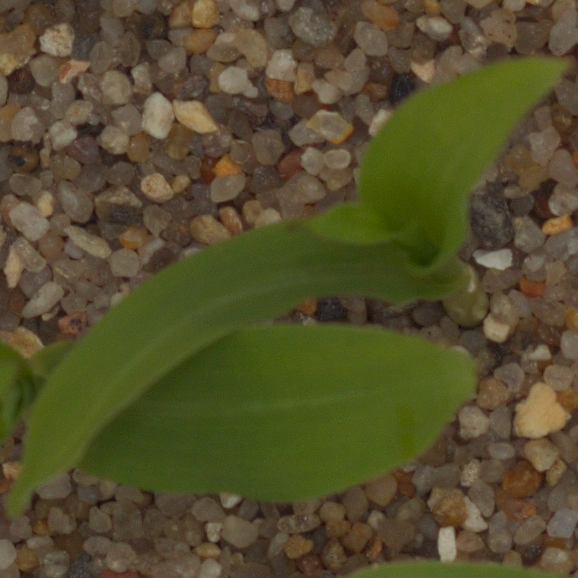

In [28]:
img # prediction image

In [29]:
img_arr.shape # prediction image size

(224, 224, 3)

### Artificial Neural Network(ANN)

In [48]:
# initialising the classifier
ann_classifier = tf.keras.models.Sequential()

# adding the Re-Shaped input layer
ann_classifier.add(tf.keras.layers.Reshape(target_shape=(IMG_WIDTH*IMG_HEIGHT*3,),input_shape=(IMG_WIDTH,IMG_HEIGHT,3,)))

In [49]:
# first hidden layer
ann_classifier.add(tf.keras.layers.BatchNormalization()) # batch normalization before the hidden layer
ann_classifier.add(tf.keras.layers.Dense(units=200)) # 200 neuron layer
ann_classifier.add(tf.keras.layers.LeakyReLU(alpha=0.01)) # adding a Leaky ReLU activation
ann_classifier.add(tf.keras.layers.Dropout(0.5)) # dropping 50% neurons

In [50]:
# output layer
ann_classifier.add(tf.keras.layers.BatchNormalization()) # batch normalization before the output layer
ann_classifier.add(tf.keras.layers.Dense(units=number_of_classes,activation='softmax')) # predicted output with softmax activation to get probability

In [51]:
# compiling a neural network classifier
# with an Adam optimizer, 
# loss calculated on categorical_cross_entropy,
# evaluated on accuracy metric
ann_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
# describing the classifier
ann_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 150528)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 150528)           602112    
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 200)               30105800  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 200)              800       
 hNormalization)                                      

In [53]:
# a model checkpoint to hold only the best accuracy model with architecture and weights
ann_classifier_checkpoint = tf.keras.callbacks.ModelCheckpoint('ann_classifier.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [54]:
# fit the model
ann_classifier_training_history = ann_classifier.fit(train_gen,
                                                     epochs=50,
                                                     callbacks=[ann_classifier_checkpoint],
                                                     validation_data=test_gen,
                                                     steps_per_epoch = train_size//BATCH_SIZE,
                                                     validation_steps = test_size//BATCH_SIZE)

Epoch 1/50
76/76 [==============================] - ETA: 0s - loss: 2.7896 - accuracy: 0.1626
Epoch 1: val_accuracy improved from -inf to 0.15263, saving model to ann_classifier.h5
76/76 [==============================] - 90s 1s/step - loss: 2.7896 - accuracy: 0.1626 - val_loss: 4.6367 - val_accuracy: 0.1526
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 2.3619 - accuracy: 0.2402
Epoch 2: val_accuracy improved from 0.15263 to 0.23789, saving model to ann_classifier.h5
76/76 [==============================] - 87s 1s/step - loss: 2.3619 - accuracy: 0.2402 - val_loss: 2.4368 - val_accuracy: 0.2379
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 2.1770 - accuracy: 0.2851
Epoch 3: val_accuracy improved from 0.23789 to 0.34947, saving model to ann_classifier.h5
76/76 [==============================] - 87s 1s/step - loss: 2.1770 - accuracy: 0.2851 - val_loss: 1.9326 - val_accuracy: 0.3495
Epoch 4/50
76/76 [==============================] - ETA: 0s - lo

In [61]:
# load best saved model
loaded_ann_classifier = tf.keras.models.load_model('ann_classifier.h5')

In [64]:
# evaluating the loaded classifier on train data
train_metrics = loaded_ann_classifier.evaluate(X_train_copy,y_train_labelled,verbose=0)

In [65]:
# evaluating the loaded classifier on test data
val_metrics = loaded_ann_classifier.evaluate(X_test_copy,y_test_labelled,verbose=0)

In [66]:
# displaying the evaluated metrics
metrics_df = pd.DataFrame(index=['Loss','Accuracy'],columns=['Training','Testing'],
                          data=[[train_metrics[0],val_metrics[0]],[train_metrics[1],val_metrics[1]]])
metrics_df

Training   Testing
Loss      1.273090  1.332560
Accuracy  0.569892  0.570231

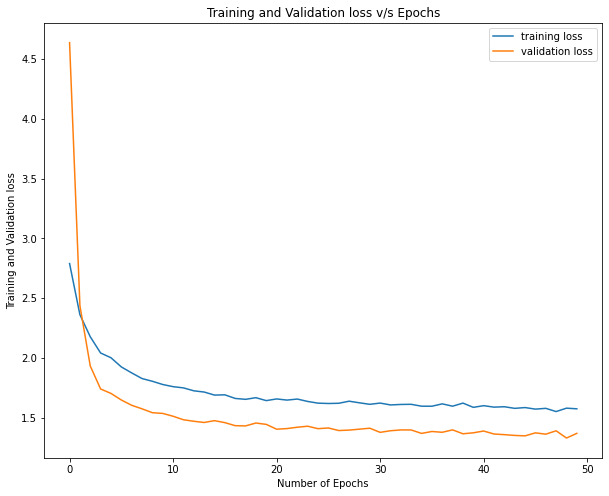

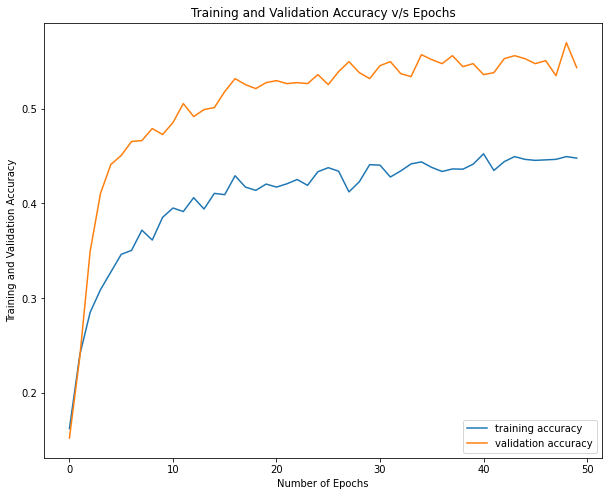

In [68]:
# call to appropriate function
plot_train_history_with_epochs(ann_classifier_training_history)

In [107]:
# making a prediction on the provided image
ann_pred = np.argmax(loaded_ann_classifier.predict(np.expand_dims(img_arr,0)))

In [108]:
ann_pred

9

In [118]:
get_predicted_class(ann_pred)

'Shepherds Purse'

#### Observations:
From training an **ANN** we can observe:
- The model is very bulky with huge number of parameters.
- The model is performing poorly on train and test data.
- The model is *not* purely over-fitting.
- The model's accuracy kept on increasing or the loss kept decreasing at a good pace, that suggests the *learning rate* is good.
- The model predicted the image as *Shepherds Purse*.

### Deep Neural Network

In [124]:
# initialising the classifier
deep_classifier = tf.keras.models.Sequential()

# adding the Re-Shaped input layer
deep_classifier.add(tf.keras.layers.Reshape(target_shape=(IMG_WIDTH*IMG_HEIGHT*3,),input_shape=(IMG_WIDTH,IMG_HEIGHT,3,)))

In [125]:
# first hidden layer
deep_classifier.add(tf.keras.layers.BatchNormalization()) # batch normalization before the hidden layer
deep_classifier.add(tf.keras.layers.Dense(units=200)) # 200 neuron layer
deep_classifier.add(tf.keras.layers.LeakyReLU(alpha=0.01)) # adding a Leaky ReLU activation
deep_classifier.add(tf.keras.layers.Dropout(0.5)) # dropping 50% neurons

In [126]:
# second hidden layer
deep_classifier.add(tf.keras.layers.BatchNormalization()) # batch normalization before the hidden layer
deep_classifier.add(tf.keras.layers.Dense(units=100, activation='relu')) # 100 neuron layer
deep_classifier.add(tf.keras.layers.Dropout(0.5)) # dropping 50% neurons

In [127]:
# third hidden layer
deep_classifier.add(tf.keras.layers.BatchNormalization()) # batch normalization before the hidden layer
deep_classifier.add(tf.keras.layers.Dense(units=50)) # 50 neuron layer
deep_classifier.add(tf.keras.layers.LeakyReLU(alpha=0.01)) # adding a Leaky ReLU activation
deep_classifier.add(tf.keras.layers.Dropout(0.5)) # dropping 50% neurons

In [128]:
# output layer
deep_classifier.add(tf.keras.layers.BatchNormalization()) # batch normalization before the output layer
deep_classifier.add(tf.keras.layers.Dense(units=number_of_classes,activation='softmax')) # predicted output with softmax activation to get probability

In [129]:
# compiling a neural network classifier
# with an RMS optimizer, 
# loss calculated on categorical_cross_entropy,
# evaluated on accuracy metric
deep_classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [130]:
# describing the classifier
deep_classifier.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 150528)            0         
                                                                 
 batch_normalization_6 (Batc  (None, 150528)           602112    
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 200)               30105800  
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 200)               0         
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 batch_normalization_7 (Batc  (None, 200)              800       
 hNormalization)                                      

In [131]:
# a model checkpoint to hold only the best accuracy model with architecture and weights
deep_classifier_checkpoint = tf.keras.callbacks.ModelCheckpoint('deep_classifier.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [132]:
# fit the model
deep_classifier_training_history = deep_classifier.fit(train_gen,
                                                     epochs=50,
                                                     callbacks=[deep_classifier_checkpoint],
                                                     validation_data=test_gen,
                                                     steps_per_epoch = train_size//BATCH_SIZE,
                                                     validation_steps = test_size//BATCH_SIZE)

Epoch 1/50
76/76 [==============================] - ETA: 0s - loss: 2.9175 - accuracy: 0.1055
Epoch 1: val_accuracy improved from -inf to 0.13263, saving model to deep_classifier.h5
76/76 [==============================] - 94s 1s/step - loss: 2.9175 - accuracy: 0.1055 - val_loss: 3.0474 - val_accuracy: 0.1326
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 2.6375 - accuracy: 0.1446
Epoch 2: val_accuracy improved from 0.13263 to 0.20526, saving model to deep_classifier.h5
76/76 [==============================] - 94s 1s/step - loss: 2.6375 - accuracy: 0.1446 - val_loss: 2.3989 - val_accuracy: 0.2053
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 2.4828 - accuracy: 0.1687
Epoch 3: val_accuracy improved from 0.20526 to 0.28526, saving model to deep_classifier.h5
76/76 [==============================] - 90s 1s/step - loss: 2.4828 - accuracy: 0.1687 - val_loss: 2.0852 - val_accuracy: 0.2853
Epoch 4/50
76/76 [==============================] - ETA: 0s -

In [133]:
# load best saved model
loaded_deep_classifier = tf.keras.models.load_model('deep_classifier.h5')

In [134]:
# evaluating the loaded classifier on train data
train_metrics = loaded_deep_classifier.evaluate(X_train_copy,y_train_labelled,verbose=0)

In [135]:
# evaluating the loaded classifier on test data
val_metrics = loaded_deep_classifier.evaluate(X_test_copy,y_test_labelled,verbose=0)

In [136]:
# displaying the evaluated metrics
metrics_df = pd.DataFrame(index=['Loss','Accuracy'],columns=['Training','Testing'],
                          data=[[train_metrics[0],val_metrics[0]],[train_metrics[1],val_metrics[1]]])
metrics_df

Training   Testing
Loss      1.442621  1.488364
Accuracy  0.507212  0.477987

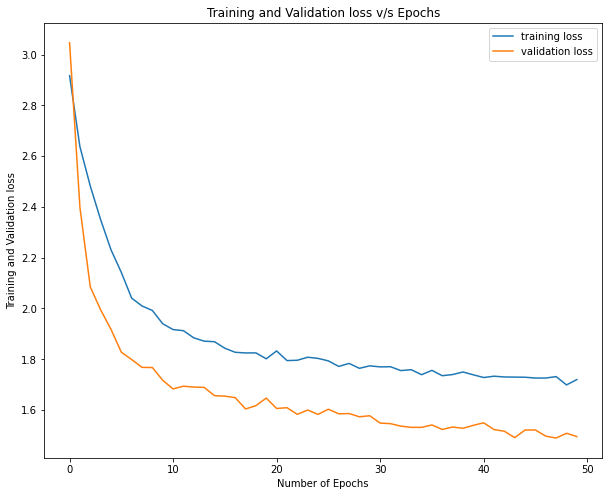

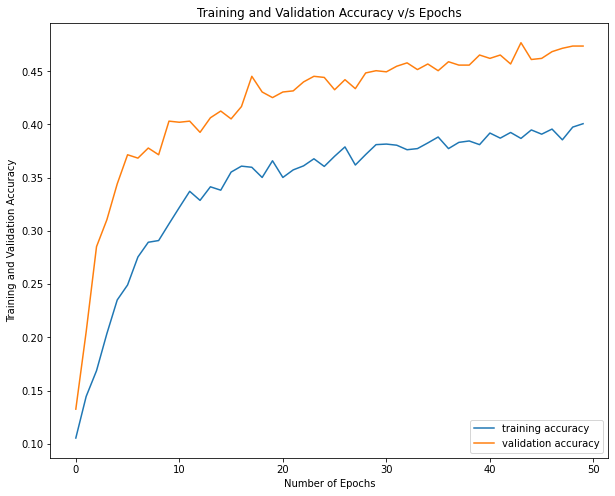

In [137]:
# call to appropriate function
plot_train_history_with_epochs(deep_classifier_training_history)

In [138]:
# making a prediction on the provided image
deep_pred = np.argmax(loaded_deep_classifier.predict(np.expand_dims(img_arr,0)))
deep_pred

3

In [139]:
get_predicted_class(deep_pred)

'Common Chickweed'

#### Observations:
From training an **Deep Neural Network** we can observe:
- The model is very bulky with huge number of parameters.
- The model is performing poorly on train and test data.
- The model is *not* purely over-fitting.
- The model's accuracy kept on increasing or the loss kept decreasing at a good pace, that suggests the *learning rate* is good.
- The model predicted the image as *Common Chickweed*.

### Convolutional Neural Network(CNN)
- *CNN* with *Fully Connected Layer*.
- *CNN* without *Fully Connected Layer*.

#### CNN with Fully Connected layer

In [142]:
# initialising the classifier
cnn_fc_classifier = tf.keras.models.Sequential()

In [143]:
# input layer
cnn_fc_classifier.add(tf.keras.layers.BatchNormalization(input_shape=(IMG_WIDTH,IMG_HEIGHT,3,))) # batch-normalization with input shape

# first hidden layer
cnn_fc_classifier.add(tf.keras.layers.Conv2D(filters=8,kernel_size=(3,3))) # convolutional layer
cnn_fc_classifier.add(tf.keras.layers.BatchNormalization()) # batch-normalization layer
cnn_fc_classifier.add(tf.keras.layers.ReLU()) # ReLu activation
cnn_fc_classifier.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2)) # max-pool layer

# second hidden layer
cnn_fc_classifier.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3))) # convolutional layer
cnn_fc_classifier.add(tf.keras.layers.BatchNormalization()) # batch-normalization layer
cnn_fc_classifier.add(tf.keras.layers.ReLU()) # ReLu activation
cnn_fc_classifier.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2)) # max-pool layer

# third hidden layer
cnn_fc_classifier.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3))) # convolutional layer
cnn_fc_classifier.add(tf.keras.layers.BatchNormalization()) # batch-normalization layer
cnn_fc_classifier.add(tf.keras.layers.ReLU()) # ReLu activation

# fully connected layer
cnn_fc_classifier.add(tf.keras.layers.Flatten())
cnn_fc_classifier.add(tf.keras.layers.Dense(units=64))  # FC layer with 64 neurons

# output classifier layer with softmax
cnn_fc_classifier.add(tf.keras.layers.Dense(units=number_of_classes,activation='softmax'))

In [144]:
# compiling a neural network classifier
# with an Adam optimizer, 
# loss calculated on categorical_cross_entropy,
# evaluated on accuracy metric
cnn_fc_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [145]:
# describing the classifier
cnn_fc_classifier.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_14 (Bat  (None, 224, 224, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 batch_normalization_15 (Bat  (None, 222, 222, 8)      32        
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 222, 222, 8)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 8)      0         
 2D)                                                             
                                                      

In [147]:
# a model checkpoint to hold only the best accuracy model with architecture and weights
cnn_fc_classifier_checkpoint = tf.keras.callbacks.ModelCheckpoint('cnn_fc_classifier.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [148]:
# fit the model
cnn_fc_classifier_training_history = cnn_fc_classifier.fit(train_gen,
                                                     epochs=100,
                                                     callbacks=[cnn_fc_classifier_checkpoint],
                                                     validation_data=test_gen,
                                                     steps_per_epoch = train_size//BATCH_SIZE,
                                                     validation_steps = test_size//BATCH_SIZE)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 26.2989 - accuracy: 0.2782
Epoch 1: val_accuracy improved from -inf to 0.19263, saving model to cnn_fc_classifier.h5
76/76 [==============================] - 102s 1s/step - loss: 26.2989 - accuracy: 0.2782 - val_loss: 3.7050 - val_accuracy: 0.1926
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 5.7728 - accuracy: 0.4015
Epoch 2: val_accuracy improved from 0.19263 to 0.25684, saving model to cnn_fc_classifier.h5
76/76 [==============================] - 93s 1s/step - loss: 5.7728 - accuracy: 0.4015 - val_loss: 4.4437 - val_accuracy: 0.2568
Epoch 3/100
76/76 [==============================] - ETA: 0s - loss: 5.7513 - accuracy: 0.4199
Epoch 3: val_accuracy improved from 0.25684 to 0.36211, saving model to cnn_fc_classifier.h5
76/76 [==============================] - 87s 1s/step - loss: 5.7513 - accuracy: 0.4199 - val_loss: 4.1902 - val_accuracy: 0.3621
Epoch 4/100
76/76 [==============================

In [149]:
# load best saved model
loaded_cnn_fc_classifier = tf.keras.models.load_model('cnn_fc_classifier.h5')

In [150]:
# evaluating the loaded classifier on train data
train_metrics = loaded_cnn_fc_classifier.evaluate(X_train_copy,y_train_labelled,verbose=0)

In [151]:
# evaluating the loaded classifier on test data
val_metrics = loaded_cnn_fc_classifier.evaluate(X_test_copy,y_test_labelled,verbose=0)

In [152]:
# displaying the evaluated metrics
metrics_df = pd.DataFrame(index=['Loss','Accuracy'],columns=['Training','Testing'],
                          data=[[train_metrics[0],val_metrics[0]],[train_metrics[1],val_metrics[1]]])
metrics_df

Training   Testing
Loss      0.255138  0.318699
Accuracy  0.919486  0.896226

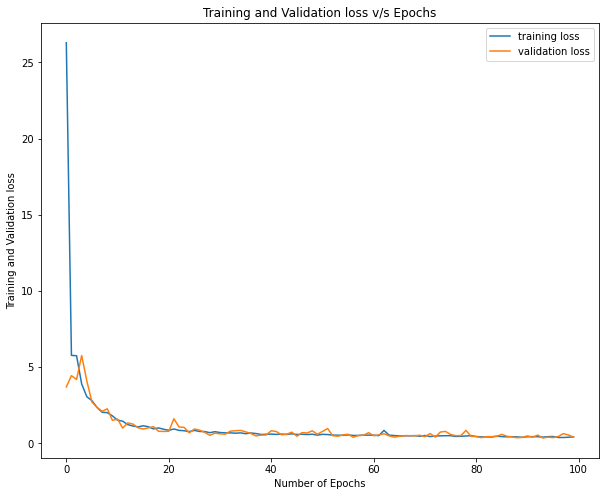

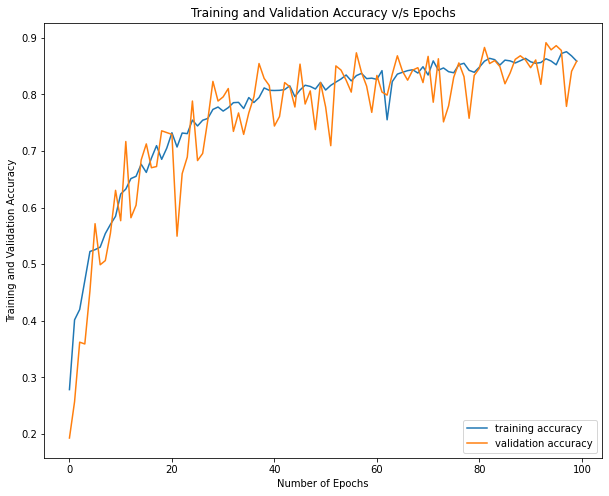

In [153]:
# call to appropriate function
plot_train_history_with_epochs(cnn_fc_classifier_training_history)

In [154]:
# making a prediction on the provided image
cnn_fc_pred = np.argmax(loaded_cnn_fc_classifier.predict(np.expand_dims(img_arr,0)))
cnn_fc_pred

7

In [155]:
get_predicted_class(cnn_fc_pred)

'Maize'

#### Observations:
From training an **CNN with FC layer** we can observe:
- The model is bulky with large number of parameters.
- The model is performing good on train and test data.
- The model is *not* over-fitting.
- The model's accuracy kept on increasing or the loss kept decreasing at a good pace, that suggests the *learning rate* is good but the *validation accuracy* kept on fluctuating a lot.
- The model predicted the image as *Maize*.

#### CNN without Fully Connected layer

In [156]:
# initialising the classifier
cnn_classifier = tf.keras.models.Sequential()

In [157]:
# input layer
cnn_classifier.add(tf.keras.layers.BatchNormalization(input_shape=(IMG_WIDTH,IMG_HEIGHT,3,))) # batch-normalization with input shape

# first hidden layer
cnn_classifier.add(tf.keras.layers.Conv2D(filters=8,kernel_size=(3,3))) # convolutional layer
cnn_classifier.add(tf.keras.layers.BatchNormalization()) # batch-normalization layer
cnn_classifier.add(tf.keras.layers.ReLU()) # ReLu activation
cnn_classifier.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2)) # max-pool layer

# second hidden layer
cnn_classifier.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3))) # convolutional layer
cnn_classifier.add(tf.keras.layers.BatchNormalization()) # batch-normalization layer
cnn_classifier.add(tf.keras.layers.ReLU()) # ReLu activation
cnn_classifier.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2)) # max-pool layer

# third hidden layer
cnn_classifier.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3))) # convolutional layer
cnn_classifier.add(tf.keras.layers.BatchNormalization()) # batch-normalization layer
cnn_classifier.add(tf.keras.layers.ReLU()) # ReLu activation

# Global Average Pooling layer
cnn_classifier.add(tf.keras.layers.GlobalAveragePooling2D())

# output classifier layer with softmax
cnn_classifier.add(tf.keras.layers.Dense(units=number_of_classes,activation='softmax'))

In [158]:
# compiling a neural network classifier
# with an Adam optimizer, 
# loss calculated on categorical_cross_entropy,
# evaluated on accuracy metric
cnn_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [159]:
# describing the classifier
cnn_classifier.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_18 (Bat  (None, 224, 224, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 batch_normalization_19 (Bat  (None, 222, 222, 8)      32        
 chNormalization)                                                
                                                                 
 re_lu_6 (ReLU)              (None, 222, 222, 8)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 8)      0         
 2D)                                                             
                                                      

In [160]:
# a model checkpoint to hold only the best accuracy model with architecture and weights
cnn_classifier_checkpoint = tf.keras.callbacks.ModelCheckpoint('cnn_classifier.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [161]:
# fit the model
cnn_classifier_training_history = cnn_classifier.fit(train_gen,
                                                     epochs=100,
                                                     callbacks=[cnn_classifier_checkpoint],
                                                     validation_data=test_gen,
                                                     steps_per_epoch = train_size//BATCH_SIZE,
                                                     validation_steps = test_size//BATCH_SIZE)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 2.2824 - accuracy: 0.2599
Epoch 1: val_accuracy improved from -inf to 0.14421, saving model to cnn_classifier.h5
76/76 [==============================] - 89s 1s/step - loss: 2.2824 - accuracy: 0.2599 - val_loss: 2.4458 - val_accuracy: 0.1442
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 1.9965 - accuracy: 0.3930
Epoch 2: val_accuracy improved from 0.14421 to 0.18000, saving model to cnn_classifier.h5
76/76 [==============================] - 89s 1s/step - loss: 1.9965 - accuracy: 0.3930 - val_loss: 2.1935 - val_accuracy: 0.1800
Epoch 3/100
76/76 [==============================] - ETA: 0s - loss: 1.8313 - accuracy: 0.4414
Epoch 3: val_accuracy improved from 0.18000 to 0.33053, saving model to cnn_classifier.h5
76/76 [==============================] - 89s 1s/step - loss: 1.8313 - accuracy: 0.4414 - val_loss: 1.9147 - val_accuracy: 0.3305
Epoch 4/100
76/76 [==============================] - ETA: 0s 

In [166]:
# fit for 20 more epochs model
cnn_classifier_training_history = cnn_classifier.fit(train_gen,
                                                     epochs=120,
                                                     initial_epoch=100,
                                                     callbacks=[cnn_classifier_checkpoint],
                                                     validation_data=test_gen,
                                                     steps_per_epoch = train_size//BATCH_SIZE,
                                                     validation_steps = test_size//BATCH_SIZE)

Epoch 101/120
76/76 [==============================] - ETA: 0s - loss: 0.5536 - accuracy: 0.8206
Epoch 101: val_accuracy did not improve from 0.81474
76/76 [==============================] - 90s 1s/step - loss: 0.5536 - accuracy: 0.8206 - val_loss: 0.6573 - val_accuracy: 0.7632
Epoch 102/120
76/76 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.8278
Epoch 102: val_accuracy did not improve from 0.81474
76/76 [==============================] - 89s 1s/step - loss: 0.5534 - accuracy: 0.8278 - val_loss: 0.5683 - val_accuracy: 0.8032
Epoch 103/120
76/76 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.8222
Epoch 103: val_accuracy did not improve from 0.81474
76/76 [==============================] - 89s 1s/step - loss: 0.5657 - accuracy: 0.8222 - val_loss: 0.6637 - val_accuracy: 0.7632
Epoch 104/120
76/76 [==============================] - ETA: 0s - loss: 0.5642 - accuracy: 0.8196
Epoch 104: val_accuracy did not improve from 0.81474
76/76 [======

In [167]:
# load best saved model
loaded_cnn_classifier = tf.keras.models.load_model('cnn_classifier.h5')

In [168]:
# evaluating the loaded classifier on train data
train_metrics = loaded_cnn_classifier.evaluate(X_train_copy,y_train_labelled,verbose=0)

In [169]:
# evaluating the loaded classifier on test data
val_metrics = loaded_cnn_classifier.evaluate(X_test_copy,y_test_labelled,verbose=0)

In [170]:
# displaying the evaluated metrics
metrics_df = pd.DataFrame(index=['Loss','Accuracy'],columns=['Training','Testing'],
                          data=[[train_metrics[0],val_metrics[0]],[train_metrics[1],val_metrics[1]]])
metrics_df

Training   Testing
Loss      0.440960  0.488057
Accuracy  0.868607  0.839623

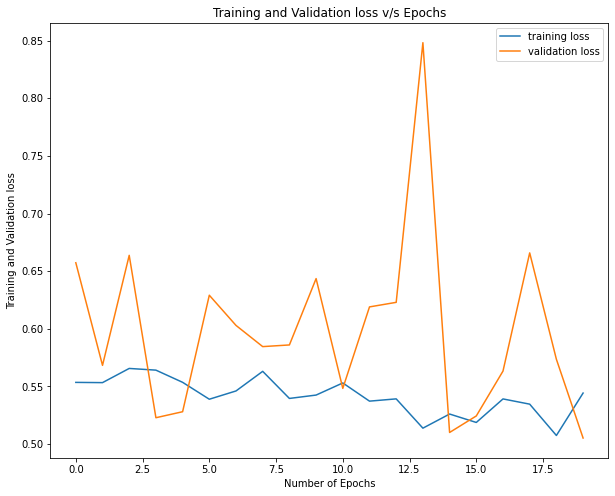

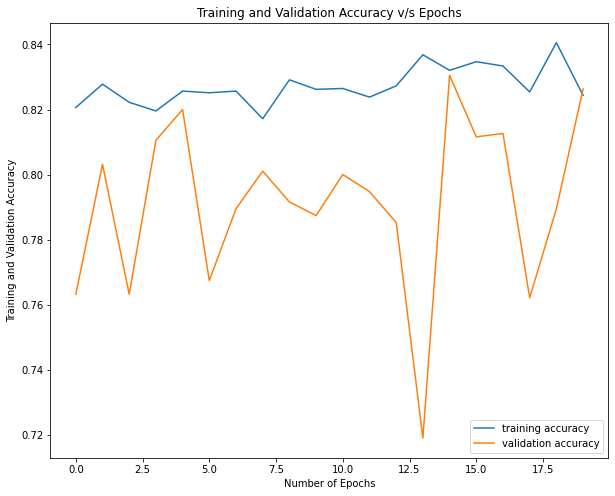

In [171]:
# call to appropriate function
plot_train_history_with_epochs(cnn_classifier_training_history)

In [172]:
# making a prediction on the provided image
cnn_pred = np.argmax(loaded_cnn_classifier.predict(np.expand_dims(img_arr,0)))
cnn_pred

7

In [173]:
get_predicted_class(cnn_pred)

'Maize'

#### Observations:
From training an **CNN without FC layer** we can observe:
- The model is very light with few number of parameters.
- The model is performing good on train and test data in terms of metrics but the trend of training the model is not satisfying. It keeps fluctuating a lot.
- The model is *not* purely over-fitting.
- The model predicted the image as *Maize*.

### Transfer Learning using pre-trained models
We will make use of some pre-trained networks on **ImageNet**
- *Xception*
- *VGG*
- *Inception*
- *ResNet*
- *MobileNet*


In [31]:
# using different batch size
BATCH_SIZE = 150

#### Xception

In [39]:
def pre_process_data_xception(img):
  '''
  This pre-processes the data like the way it was done while training the module
  '''
  return tf.keras.applications.xception.preprocess_input(img)

In [40]:
# Training data generator with augmentation
train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            horizontal_flip=True,
                                                            preprocessing_function=pre_process_data_xception)

# Test data generator without augmentation
test_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pre_process_data_xception)

In [41]:
# flow from dataframe based on the generator
train_gen = train_img_gen.flow_from_dataframe(dataframe=train_df,
                                              x_col='IMAGE_PATH',
                                              y_col='IMAGE_CLASS',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              batch_size = BATCH_SIZE)

test_gen = test_img_gen.flow_from_dataframe(dataframe=test_df,
                                            x_col='IMAGE_PATH',
                                            y_col='IMAGE_CLASS',
                                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                                            batch_size = BATCH_SIZE)

Found 3813 validated image filenames belonging to 12 classes.
Found 954 validated image filenames belonging to 12 classes.


In [42]:
# load the pre-trained model without the last layer
xception_net_pre_trained = tf.keras.applications.xception.Xception(include_top=False, # don't include the last layer
                                                                   weights='imagenet', # trained on imagenet
                                                                   input_shape= (IMG_WIDTH,IMG_HEIGHT,3)
                                                                   )

83697664/83683744 [==============================] - 1s 0us/step


In [43]:
print(f'Number of layers in Xception {len(xception_net_pre_trained.layers)}')

Number of layers in Xception 132


In [44]:
# set all the trainable parametrs to false
for layer in xception_net_pre_trained.layers:
  layer.trainable = False

# we can also freeze only certain layers based on our requirement

In [45]:
# adding our layers to the pre-trained frozen model
x1 = xception_net_pre_trained.output # getting the last output

x2 = tf.keras.layers.GlobalAveragePooling2D()(x1) # connecting the output of trained model to Global Average Pooling layer

# connecting Global Average Pooling layer to the output layer
out = tf.keras.layers.Dense(units=number_of_classes, activation='softmax')(x2)

In [46]:
# building the final model
xception_net = tf.keras.models.Model(inputs=xception_net_pre_trained.input, # pre-trained model as input
                                    outputs=out # output layer
                                    )

In [47]:
# compiling a neural network classifier
# with an Adam optimizer, 
# loss calculated on categorical_cross_entropy,
# evaluated on accuracy metric
xception_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
# describing the classifier
xception_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [49]:
# a model checkpoint to hold only the best accuracy model with architecture and weights
xception_checkpoint = tf.keras.callbacks.ModelCheckpoint('xception.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [50]:
# fit the model
xception_training_history = xception_net.fit(train_gen,
                                            epochs=50,
                                            callbacks=[xception_checkpoint],
                                            validation_data=test_gen,
                                            steps_per_epoch = train_size//BATCH_SIZE,
                                            validation_steps = test_size//BATCH_SIZE)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 2.1733 - accuracy: 0.2864
Epoch 1: val_accuracy improved from -inf to 0.42778, saving model to xception.h5
25/25 [==============================] - 99s 4s/step - loss: 2.1733 - accuracy: 0.2864 - val_loss: 1.8565 - val_accuracy: 0.4278
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.7132 - accuracy: 0.4701
Epoch 2: val_accuracy improved from 0.42778 to 0.51333, saving model to xception.h5
25/25 [==============================] - 89s 4s/step - loss: 1.7132 - accuracy: 0.4701 - val_loss: 1.5516 - val_accuracy: 0.5133
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.4854 - accuracy: 0.5441
Epoch 3: val_accuracy improved from 0.51333 to 0.57556, saving model to xception.h5
25/25 [==============================] - 89s 4s/step - loss: 1.4854 - accuracy: 0.5441 - val_loss: 1.3842 - val_accuracy: 0.5756
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 1.3444 - accur

In [51]:
# load best saved model
loaded_xception_classifier = tf.keras.models.load_model('xception.h5')

In [77]:
idx = np.argmax(xception_training_history.history['val_accuracy'])

# loss metrics
train_loss = xception_training_history.history['loss'][idx]
test_loss = xception_training_history.history['val_loss'][idx]

# accuracy metrics
train_acc = xception_training_history.history['accuracy'][idx]
test_acc = xception_training_history.history['val_accuracy'][idx]

In [78]:
# displaying the evaluated metrics
metrics_df = pd.DataFrame(index=['Loss','Accuracy'],columns=['Training','Testing'],
                          data=[[train_loss,test_loss],[train_acc,test_acc]])
metrics_df

Training   Testing
Loss      0.597765  0.660922
Accuracy  0.814360  0.788889

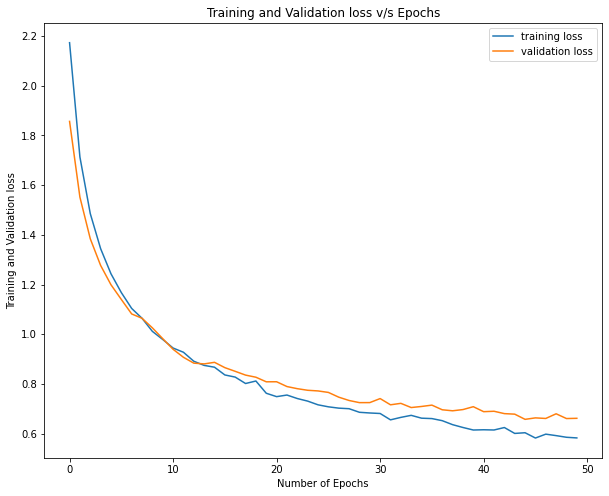

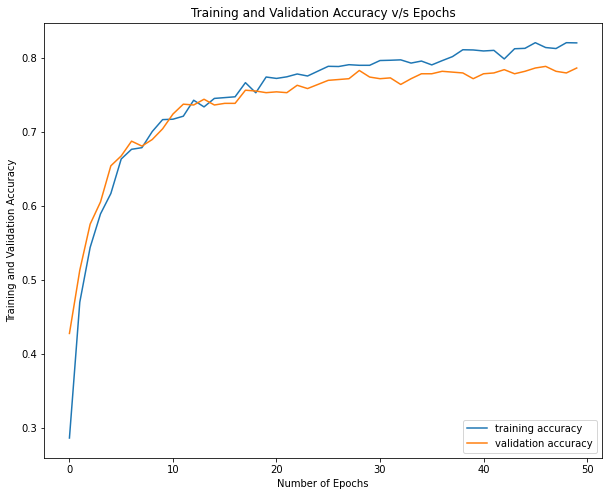

In [79]:
# call to appropriate function
plot_train_history_with_epochs(xception_training_history)

In [80]:
# making a prediction on the provided image
xception_pred = np.argmax(loaded_xception_classifier.predict(np.expand_dims(img_arr,0)))
xception_pred

7

In [81]:
get_predicted_class(xception_pred)

'Maize'

#### Observations:
From training an **pre-trained Xception** we can observe:
- The model is light-weight with less number of *trainable* parameters as the *pre-trained* layers have been frozen and we train only the classifier.
- The model is performing good on train and test data.
- The model is *not* over-fitting.
- The model's accuracy kept on increasing or the loss kept decreasing at a good pace, that suggests the *learning rate* is good.
- The model predicted the image as *Maize*.

#### VGG

In [30]:
def pre_process_data_vgg(img):
  '''
  This pre-processes the data like the way it was done while training the module
  '''
  return tf.keras.applications.vgg16.preprocess_input(img)

In [32]:
# Training data generator with augmentation
train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            horizontal_flip=True,
                                                            preprocessing_function=pre_process_data_vgg)

# Test data generator without augmentation
test_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pre_process_data_vgg)

In [33]:
# flow from dataframe based on the generator
train_gen = train_img_gen.flow_from_dataframe(dataframe=train_df,
                                              x_col='IMAGE_PATH',
                                              y_col='IMAGE_CLASS',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              batch_size = BATCH_SIZE)

test_gen = test_img_gen.flow_from_dataframe(dataframe=test_df,
                                            x_col='IMAGE_PATH',
                                            y_col='IMAGE_CLASS',
                                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                                            batch_size = BATCH_SIZE)

Found 3813 validated image filenames belonging to 12 classes.
Found 954 validated image filenames belonging to 12 classes.


In [34]:
train_size = len(train_gen.filenames)
test_size = len(test_gen.filenames)

In [35]:
# load the pre-trained model without the last layer
vgg_net_pre_trained = tf.keras.applications.vgg16.VGG16(include_top=False, # don't include the last layer
                                                        weights='imagenet', # trained on imagenet
                                                        input_shape= (IMG_WIDTH,IMG_HEIGHT,3)
                                                        )

58900480/58889256 [==============================] - 0s 0us/step


In [36]:
print(f'Number of layers in VGG16 {len(vgg_net_pre_trained.layers)}')

Number of layers in VGG16 19


In [37]:
# set all the trainable parametrs to false
for layer in vgg_net_pre_trained.layers:
  layer.trainable = False

# we can also freeze only certain layers based on our requirement

In [38]:
# adding our layers to the pre-trained frozen model
x1 = vgg_net_pre_trained.output # getting the last output

x2 = tf.keras.layers.GlobalAveragePooling2D()(x1) # connecting the output of trained model to Global Average Pooling layer

# connecting Global Average Pooling layer to the output layer
out = tf.keras.layers.Dense(units=number_of_classes, activation='softmax')(x2)

In [39]:
# building the final model
vgg = tf.keras.models.Model(inputs=vgg_net_pre_trained.input, # pre-trained model as input
                            outputs=out # output layer
                            )

In [40]:
# compiling a neural network classifier
# with an Adam optimizer, 
# loss calculated on categorical_cross_entropy,
# evaluated on accuracy metric
vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
# describing the classifier
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [42]:
# a model checkpoint to hold only the best accuracy model with architecture and weights
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [43]:
# fit the model
vgg_training_history = vgg.fit(train_gen,
                                epochs=50,
                                callbacks=[vgg_checkpoint],
                                validation_data=test_gen,
                                steps_per_epoch = train_size//BATCH_SIZE,
                                validation_steps = test_size//BATCH_SIZE)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 4.0997 - accuracy: 0.1395
Epoch 1: val_accuracy improved from -inf to 0.18889, saving model to vgg.h5
25/25 [==============================] - 104s 4s/step - loss: 4.0997 - accuracy: 0.1395 - val_loss: 3.7229 - val_accuracy: 0.1889
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 2.5873 - accuracy: 0.2596
Epoch 2: val_accuracy improved from 0.18889 to 0.27222, saving model to vgg.h5
25/25 [==============================] - 89s 4s/step - loss: 2.5873 - accuracy: 0.2596 - val_loss: 2.6826 - val_accuracy: 0.2722
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 2.0308 - accuracy: 0.3615
Epoch 3: val_accuracy improved from 0.27222 to 0.37000, saving model to vgg.h5
25/25 [==============================] - 87s 3s/step - loss: 2.0308 - accuracy: 0.3615 - val_loss: 2.0849 - val_accuracy: 0.3700
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 1.6921 - accuracy: 0.4363
Ep

In [44]:
# load best saved model
loaded_vgg_classifier = tf.keras.models.load_model('vgg.h5')

In [45]:
idx = np.argmax(vgg_training_history.history['val_accuracy'])

# loss metrics
train_loss = vgg_training_history.history['loss'][idx]
test_loss = vgg_training_history.history['val_loss'][idx]

# accuracy metrics
train_acc = vgg_training_history.history['accuracy'][idx]
test_acc = vgg_training_history.history['val_accuracy'][idx]

In [46]:
# displaying the evaluated metrics
metrics_df = pd.DataFrame(index=['Loss','Accuracy'],columns=['Training','Testing'],
                          data=[[train_loss,test_loss],[train_acc,test_acc]])
metrics_df

Training   Testing
Loss      0.457411  0.624372
Accuracy  0.852034  0.795556

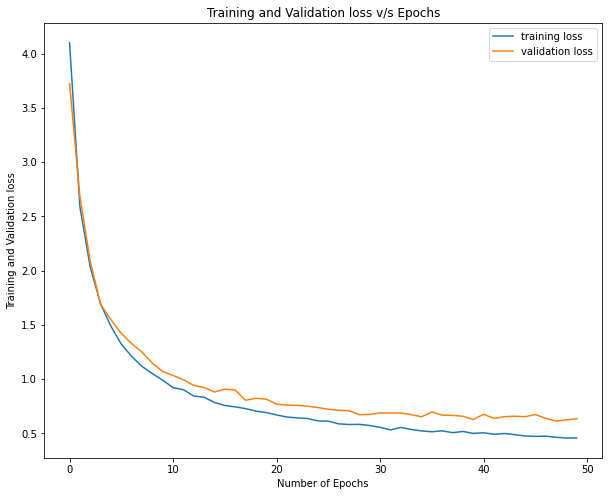

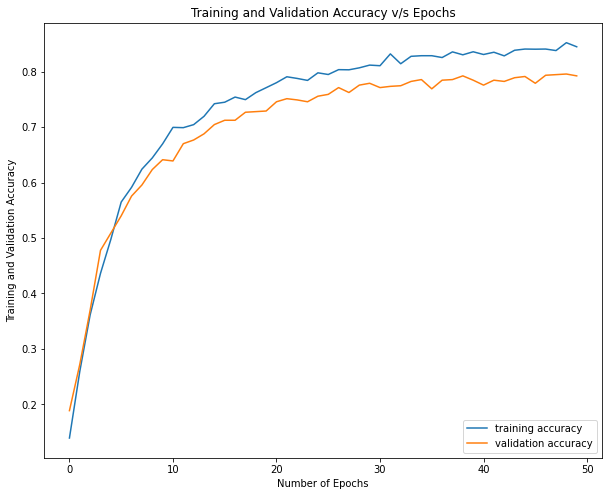

In [47]:
# call to appropriate function
plot_train_history_with_epochs(vgg_training_history)

In [48]:
# making a prediction on the provided image
vgg_pred = np.argmax(loaded_vgg_classifier.predict(np.expand_dims(img_arr,0)))
vgg_pred

7

In [49]:
get_predicted_class(vgg_pred)

'Maize'

#### Observations:
From training an **pre-trained VGG** we can observe:
- The model is light-weight with less number of *trainable* parameters as the *pre-trained* layers have been frozen and we train only the classifier.
- The model is performing good on train and test data.
- The model is *not* over-fitting.
- The model's accuracy kept on increasing or the loss kept decreasing at a good pace, that suggests the *learning rate* is good.
- The model predicted the image as *Maize*.

#### Inception Network

In [50]:
def pre_process_data_inception(img):
  '''
  This pre-processes the data like the way it was done while training the module
  '''
  return tf.keras.applications.inception_v3.preprocess_input(img)

In [51]:
# Training data generator with augmentation
train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            horizontal_flip=True,
                                                            preprocessing_function=pre_process_data_inception)

# Test data generator without augmentation
test_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pre_process_data_inception)

In [52]:
# flow from dataframe based on the generator
train_gen = train_img_gen.flow_from_dataframe(dataframe=train_df,
                                              x_col='IMAGE_PATH',
                                              y_col='IMAGE_CLASS',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              batch_size = BATCH_SIZE)

test_gen = test_img_gen.flow_from_dataframe(dataframe=test_df,
                                            x_col='IMAGE_PATH',
                                            y_col='IMAGE_CLASS',
                                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                                            batch_size = BATCH_SIZE)

Found 3813 validated image filenames belonging to 12 classes.
Found 954 validated image filenames belonging to 12 classes.


In [53]:
# load the pre-trained model without the last layer
inception_pre_trained = tf.keras.applications.inception_v3.InceptionV3(include_top=False, # don't include the last layer
                                                                   weights='imagenet', # trained on imagenet
                                                                   input_shape= (IMG_WIDTH,IMG_HEIGHT,3)
                                                                   )

87924736/87910968 [==============================] - 1s 0us/step


In [54]:
print(f'Number of layers in Inception_V3 {len(inception_pre_trained.layers)}')

Number of layers in Inception_V3 311


In [55]:
# set all the trainable parametrs to false
for layer in inception_pre_trained.layers:
  layer.trainable = False

# we can also freeze only certain layers based on our requirement

In [56]:
# adding our layers to the pre-trained frozen model
x1 = inception_pre_trained.output # getting the last output

x2 = tf.keras.layers.GlobalAveragePooling2D()(x1) # connecting the output of trained model to Global Average Pooling layer

# connecting Global Average Pooling layer to the output layer
out = tf.keras.layers.Dense(units=number_of_classes, activation='softmax')(x2)

In [57]:
# building the final model
inception_net = tf.keras.models.Model(inputs=inception_pre_trained.input, # pre-trained model as input
                                    outputs=out # output layer
                                    )

In [58]:
# compiling a neural network classifier
# with an Adam optimizer, 
# loss calculated on categorical_cross_entropy,
# evaluated on accuracy metric
inception_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# describing the classifier
inception_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [60]:
# a model checkpoint to hold only the best accuracy model with architecture and weights
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint('inception.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [61]:
# fit the model
inception_training_history = inception_net.fit(train_gen,
                                            epochs=50,
                                            callbacks=[inception_checkpoint],
                                            validation_data=test_gen,
                                            steps_per_epoch = train_size//BATCH_SIZE,
                                            validation_steps = test_size//BATCH_SIZE)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 2.2750 - accuracy: 0.2735
Epoch 1: val_accuracy improved from -inf to 0.39444, saving model to inception.h5
25/25 [==============================] - 93s 4s/step - loss: 2.2750 - accuracy: 0.2735 - val_loss: 1.7759 - val_accuracy: 0.3944
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.5651 - accuracy: 0.4909
Epoch 2: val_accuracy improved from 0.39444 to 0.48000, saving model to inception.h5
25/25 [==============================] - 87s 3s/step - loss: 1.5651 - accuracy: 0.4909 - val_loss: 1.4836 - val_accuracy: 0.4800
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.3567 - accuracy: 0.5528
Epoch 3: val_accuracy improved from 0.48000 to 0.58778, saving model to inception.h5
25/25 [==============================] - 87s 3s/step - loss: 1.3567 - accuracy: 0.5528 - val_loss: 1.2792 - val_accuracy: 0.5878
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 1.1991 - ac

In [62]:
# load best saved model
loaded_inception_classifier = tf.keras.models.load_model('inception.h5')

In [63]:
idx = np.argmax(inception_training_history.history['val_accuracy'])

# loss metrics
train_loss = inception_training_history.history['loss'][idx]
test_loss = inception_training_history.history['val_loss'][idx]

# accuracy metrics
train_acc = inception_training_history.history['accuracy'][idx]
test_acc = inception_training_history.history['val_accuracy'][idx]

In [64]:
# displaying the evaluated metrics
metrics_df = pd.DataFrame(index=['Loss','Accuracy'],columns=['Training','Testing'],
                          data=[[train_loss,test_loss],[train_acc,test_acc]])
metrics_df

Training   Testing
Loss      0.540800  0.575286
Accuracy  0.823642  0.822222

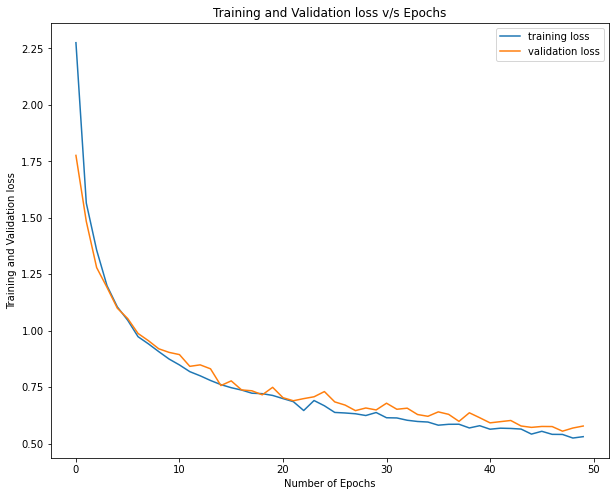

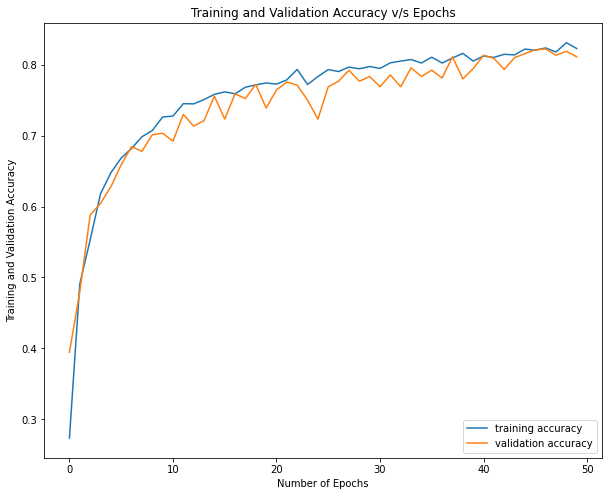

In [65]:
# call to appropriate function
plot_train_history_with_epochs(inception_training_history)

In [69]:
# making a prediction on the provided image
inception_pred = np.argmax(loaded_inception_classifier.predict(np.expand_dims(img_arr,0)))
inception_pred

6

In [70]:
get_predicted_class(inception_pred)

'Loose Silky-bent'

#### Observations:
From training an **pre-trained Inception** we can observe:
- The model is light-weight with less number of *trainable* parameters as the *pre-trained* layers have been frozen and we train only the classifier.
- The model is performing good on train and test data.
- The model is *not* over-fitting.
- The model's accuracy kept on increasing or the loss kept decreasing at a good pace, that suggests the *learning rate* is good but the *validation accuracy* kept on fluctuating a little.
- The model predicted the image as *Loose Silky-bent*.

### Residual Network(ResNet)

In [71]:
def pre_process_data_resnet(img):
  '''
  This pre-processes the data like the way it was done while training the module
  '''
  return tf.keras.applications.resnet_v2.preprocess_input(img)

In [72]:
# Training data generator with augmentation
train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            horizontal_flip=True,
                                                            preprocessing_function=pre_process_data_resnet)

# Test data generator without augmentation
test_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pre_process_data_resnet)

In [74]:
# flow from dataframe based on the generator
train_gen = train_img_gen.flow_from_dataframe(dataframe=train_df,
                                              x_col='IMAGE_PATH',
                                              y_col='IMAGE_CLASS',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              batch_size = BATCH_SIZE)

test_gen = test_img_gen.flow_from_dataframe(dataframe=test_df,
                                            x_col='IMAGE_PATH',
                                            y_col='IMAGE_CLASS',
                                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                                            batch_size = BATCH_SIZE)

Found 3813 validated image filenames belonging to 12 classes.
Found 954 validated image filenames belonging to 12 classes.


In [75]:
# load the pre-trained model without the last layer
resnet_pre_trained = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, # don't include the last layer
                                                                   weights='imagenet', # trained on imagenet
                                                                   input_shape= (IMG_WIDTH,IMG_HEIGHT,3)
                                                                   )

94683136/94668760 [==============================] - 0s 0us/step


In [76]:
print(f'Number of layers in ResNet50V2 {len(resnet_pre_trained.layers)}')

Number of layers in ResNet50V2 190


In [77]:
# set all the trainable parametrs to false
for layer in resnet_pre_trained.layers:
  layer.trainable = False

# we can also freeze only certain layers based on our requirement

In [78]:
# adding our layers to the pre-trained frozen model
x1 = resnet_pre_trained.output # getting the last output

x2 = tf.keras.layers.GlobalAveragePooling2D()(x1) # connecting the output of trained model to Global Average Pooling layer

# connecting Global Average Pooling layer to the output layer
out = tf.keras.layers.Dense(units=number_of_classes, activation='softmax')(x2)

In [79]:
# building the final model
resnet50_v2 = tf.keras.models.Model(inputs=resnet_pre_trained.input, # pre-trained model as input
                                    outputs=out # output layer
                                    )

In [80]:
# compiling a neural network classifier
# with an Adam optimizer, 
# loss calculated on categorical_cross_entropy,
# evaluated on accuracy metric
resnet50_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
# describing the classifier
resnet50_v2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [82]:
# a model checkpoint to hold only the best accuracy model with architecture and weights
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [83]:
# fit the model
resnet_training_history = resnet50_v2.fit(train_gen,
                                            epochs=50,
                                            callbacks=[resnet_checkpoint],
                                            validation_data=test_gen,
                                            steps_per_epoch = train_size//BATCH_SIZE,
                                            validation_steps = test_size//BATCH_SIZE)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 2.0913 - accuracy: 0.3221
Epoch 1: val_accuracy improved from -inf to 0.48444, saving model to resnet.h5
25/25 [==============================] - 93s 4s/step - loss: 2.0913 - accuracy: 0.3221 - val_loss: 1.5048 - val_accuracy: 0.4844
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.4046 - accuracy: 0.5485
Epoch 2: val_accuracy improved from 0.48444 to 0.63667, saving model to resnet.h5
25/25 [==============================] - 86s 3s/step - loss: 1.4046 - accuracy: 0.5485 - val_loss: 1.1399 - val_accuracy: 0.6367
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.1285 - accuracy: 0.6478
Epoch 3: val_accuracy improved from 0.63667 to 0.70778, saving model to resnet.h5
25/25 [==============================] - 87s 3s/step - loss: 1.1285 - accuracy: 0.6478 - val_loss: 0.9826 - val_accuracy: 0.7078
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.9717 - accuracy: 0

In [84]:
# load best saved model
loaded_resnet_classifier = tf.keras.models.load_model('resnet.h5')

In [85]:
idx = np.argmax(resnet_training_history.history['val_accuracy'])

# loss metrics
train_loss = resnet_training_history.history['loss'][idx]
test_loss = resnet_training_history.history['val_loss'][idx]

# accuracy metrics
train_acc = resnet_training_history.history['accuracy'][idx]
test_acc = resnet_training_history.history['val_accuracy'][idx]

In [86]:
# displaying the evaluated metrics
metrics_df = pd.DataFrame(index=['Loss','Accuracy'],columns=['Training','Testing'],
                          data=[[train_loss,test_loss],[train_acc,test_acc]])
metrics_df

Training   Testing
Loss      0.330203  0.390221
Accuracy  0.894622  0.872222

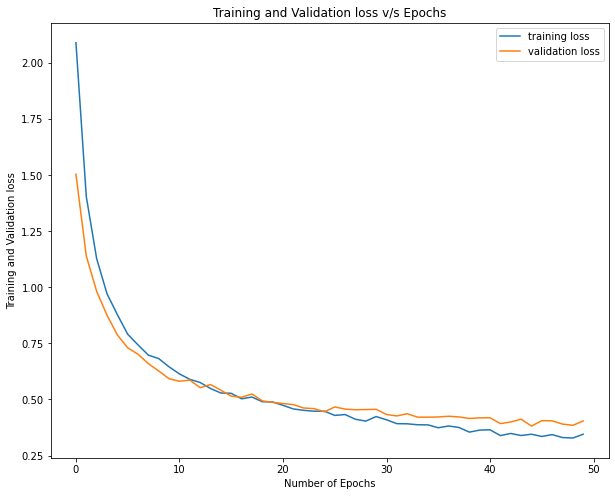

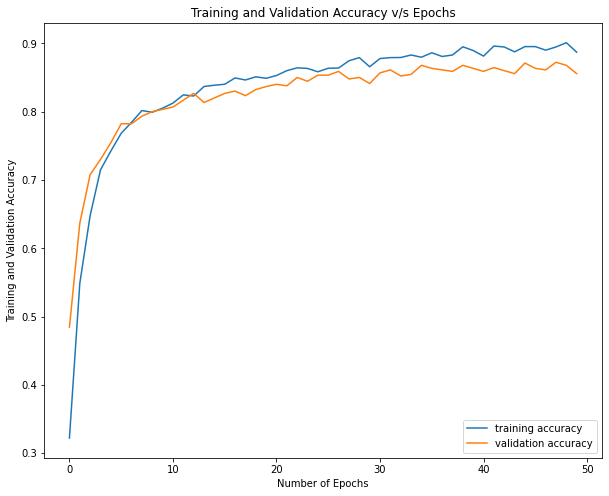

In [87]:
# call to appropriate function
plot_train_history_with_epochs(resnet_training_history)

In [88]:
# making a prediction on the provided image
resnet_pred = np.argmax(loaded_resnet_classifier.predict(np.expand_dims(img_arr,0)))
resnet_pred

7

In [89]:
get_predicted_class(resnet_pred)

'Maize'

#### Observations:
From training an **pre-trained ResNet** we can observe:
- The model is light-weight with less number of *trainable* parameters as the *pre-trained* layers have been frozen and we train only the classifier.
- The model is performing very good on train and test data.
- The model is *not* over-fitting.
- The model's accuracy kept on increasing or the loss kept decreasing at a good pace, that suggests the *learning rate* is good.
- The model predicted the image as *Maize*.

#### MobileNet

In [90]:
def pre_process_data_mobile_net(img):
  '''
  This pre-processes the data like the way it was done while training the module
  '''
  return tf.keras.applications.mobilenet_v2.preprocess_input(img)

In [91]:
# Training data generator with augmentation
train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            horizontal_flip=True,
                                                            preprocessing_function=pre_process_data_mobile_net)

# Test data generator without augmentation
test_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pre_process_data_mobile_net)

In [92]:
# flow from dataframe based on the generator
train_gen = train_img_gen.flow_from_dataframe(dataframe=train_df,
                                              x_col='IMAGE_PATH',
                                              y_col='IMAGE_CLASS',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              batch_size = BATCH_SIZE)

test_gen = test_img_gen.flow_from_dataframe(dataframe=test_df,
                                            x_col='IMAGE_PATH',
                                            y_col='IMAGE_CLASS',
                                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                                            batch_size = BATCH_SIZE)

Found 3813 validated image filenames belonging to 12 classes.
Found 954 validated image filenames belonging to 12 classes.


In [93]:
# load the pre-trained model without the last layer
mobile_net_pre_trained = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, # don't include the last layer
                                                                   weights='imagenet', # trained on imagenet
                                                                   input_shape= (IMG_WIDTH,IMG_HEIGHT,3)
                                                                   )

9420800/9406464 [==============================] - 0s 0us/step


In [94]:
print(f'Number of layers in MobileNetV2 {len(mobile_net_pre_trained.layers)}')

Number of layers in MobileNetV2 154


In [95]:
# set all the trainable parametrs to false
for layer in mobile_net_pre_trained.layers:
  layer.trainable = False

# we can also freeze only certain layers based on our requirement

In [96]:
# adding our layers to the pre-trained frozen model
x1 = mobile_net_pre_trained.output # getting the last output

x2 = tf.keras.layers.GlobalAveragePooling2D()(x1) # connecting the output of trained model to Global Average Pooling layer

# connecting Global Average Pooling layer to the output layer
out = tf.keras.layers.Dense(units=number_of_classes, activation='softmax')(x2)

In [97]:
# building the final model
mobile_net_v2 = tf.keras.models.Model(inputs=mobile_net_pre_trained.input, # pre-trained model as input
                                    outputs=out # output layer
                                    )

In [98]:
# compiling a neural network classifier
# with an Adam optimizer, 
# loss calculated on categorical_cross_entropy,
# evaluated on accuracy metric
mobile_net_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [99]:
# describing the classifier
mobile_net_v2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [100]:
# a model checkpoint to hold only the best accuracy model with architecture and weights
mobilenet_checkpoint = tf.keras.callbacks.ModelCheckpoint('mobilenet.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [101]:
# fit the model
mobilenet_training_history = mobile_net_v2.fit(train_gen,
                                            epochs=50,
                                            callbacks=[mobilenet_checkpoint],
                                            validation_data=test_gen,
                                            steps_per_epoch = train_size//BATCH_SIZE,
                                            validation_steps = test_size//BATCH_SIZE)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 2.3051 - accuracy: 0.2553
Epoch 1: val_accuracy improved from -inf to 0.43111, saving model to mobilenet.h5
25/25 [==============================] - 97s 4s/step - loss: 2.3051 - accuracy: 0.2553 - val_loss: 1.6866 - val_accuracy: 0.4311
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.4997 - accuracy: 0.5111
Epoch 2: val_accuracy improved from 0.43111 to 0.58778, saving model to mobilenet.h5
25/25 [==============================] - 85s 3s/step - loss: 1.4997 - accuracy: 0.5111 - val_loss: 1.2868 - val_accuracy: 0.5878
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.1966 - accuracy: 0.6164
Epoch 3: val_accuracy improved from 0.58778 to 0.67333, saving model to mobilenet.h5
25/25 [==============================] - 85s 3s/step - loss: 1.1966 - accuracy: 0.6164 - val_loss: 1.0702 - val_accuracy: 0.6733
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 1.0317 - ac

In [102]:
# load best saved model
loaded_mobilenet_classifier = tf.keras.models.load_model('mobilenet.h5')

In [103]:
idx = np.argmax(mobilenet_training_history.history['val_accuracy'])

# loss metrics
train_loss = mobilenet_training_history.history['loss'][idx]
test_loss = mobilenet_training_history.history['val_loss'][idx]

# accuracy metrics
train_acc = mobilenet_training_history.history['accuracy'][idx]
test_acc = mobilenet_training_history.history['val_accuracy'][idx]

In [104]:
# displaying the evaluated metrics
metrics_df = pd.DataFrame(index=['Loss','Accuracy'],columns=['Training','Testing'],
                          data=[[train_loss,test_loss],[train_acc,test_acc]])
metrics_df

Training   Testing
Loss      0.383595  0.530318
Accuracy  0.876604  0.833333

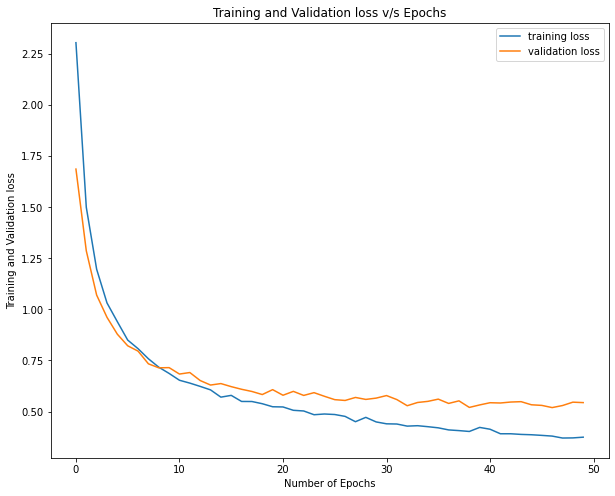

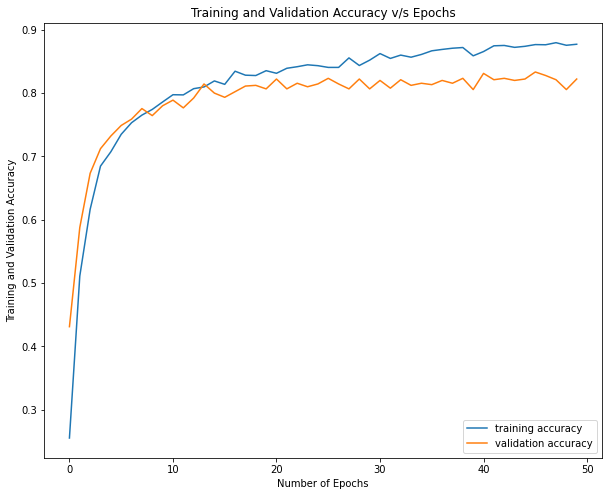

In [105]:
# call to appropriate function
plot_train_history_with_epochs(mobilenet_training_history)

In [112]:
# making a prediction on the provided image
mobilenet_pred = np.argmax(loaded_mobilenet_classifier.predict(np.expand_dims(img_arr,0)))
mobilenet_pred

6

In [113]:
get_predicted_class(mobilenet_pred)

'Loose Silky-bent'

#### Observations:
From training an **pre-trained MobileNet** we can observe:
- The model is light-weight with less number of *trainable* parameters as the *pre-trained* layers have been frozen and we train only the classifier.
- The model is performing good on train and test data.
- The model is *not* over-fitting.
- The model's accuracy kept on increasing or the loss kept decreasing at a good pace, that suggests the *learning rate* is good but the *validation accuracy* kept on fluctuating a little.
- The model predicted the image as *Loose Silky-bent*.

## Observations and Conclusions:
These are the observations and conclusions in accordance to the observations made at each section above.
- The images that were provided for training and validating the classifier where of different resolutions and a lot of background in them, so **re-sizing** was very necessary to keep the input to the classifier uniform.
- There were **12 plant classes** and some of the classes contained higher samples than others, so data was **imbalanced**.
- I resorted to **image-augmentation** on *train-data* for *neural-networks* due to limited data.
- We could have even split the data into *train*, *validation* and *test* sets.
- The **12 plant classes** with their encodings are:
  + `Black-grass`: 0
  + `Charlock`: 1
  + `Cleavers`: 2
  + `Common Chickweed`: 3
  + `Common wheat`: 4
  + `Fat Hen`: 5
  + `Loose Silky-bent`: 6
  + `Maize`: 7
  + `Scentless Mayweed`: 8
  + `Shepherds Purse`: 9
  + `Small-flowered Cranesbill`: 10
  + `Sugar beet`: 11
- When I tried to run *traditional machine-learning classifiers* like *Support Vector Machine(SVM)*, *Decision Tree*, *Random Forest* on the image-data, the classifiers performed very poorly on the *valdation-data* with **high loss** & **low accuracy** and clearly **over-fitted**.
- Also, when **Grid Search or Random Search Cross Validation** were incorporated with the *traditional ML* classifiers for this image-data-set, the process became very very slow.
- Also, even the *best hyper-parameters* from the *hyper-parameter tuning searches* couldn't improve the model performance which is very evident from **confusion-matrix**, **classification-report** etc. This is because these classifiers we need to supply proper features extracted by feature engineering.
- So we outsourced the **feature-extraction** process to the **Neural Networks**.
- I started with **Single Hidden Layer Neural Network** with **dense/fully-connected**, **batch-normalization**, **dropout** layers and **LeakyReLU** activations.
  + The model was very *bulky* with millions of *trainable* parameters.
  + The model performed very poor with a very **high loss** and **low accuracy**.
  + The model predicted the provided image as *Shepherds Purse*.
- Then I used a with **Deep Neural Network** with multiple **dense/fully-connected**, **batch-normalization**, **dropout** layers and **LeakyReLU** and **ReLU** activations.
  + The model was very *bulky* with millions of *trainable* parameters.
  + The model performed very poor with a very **high loss** and **low accuracy**.
  + The model predicted the provided image as *Common Chickweed*.
- Then I used a with **Convolutional Neural Network** with multiple **dense/fully-connected**, **batch-normalization**, **dropout** layers and **ReLU** activations.
  + The model was *bulky* with millions of *trainable* parameters.
  + The model performed very good with a very **low loss** and **high accuracy** but trained for large **epochs** and smaller **batch-size**.
  + The model predicted the provided image as *Maize*.
- Then I used a with **Convolutional Neural Network** with multiple **Global Average Pooling**, **batch-normalization**, **dropout** layers and **ReLU** activations.
  + The model was very *light-weight* with thousands of *trainable* parameters.
  + The model performed very good with a very **low loss** and **high accuracy** but trained for large **epochs** and smaller **batch-size**.
  + The model predicted the provided image as *Maize*.
- Then I used a with **Transfer Learning** technique, in which I used *pre-trained* models from *ImageNet* data-set like **Xception**, **VGG16**, **InceptionV3**, **ResNet50**, **MobileNet**.
  + These models conatined millions of trainable parameters, but I **froze** all the layers with their already trained weights due to limited data.
  + To these models I added **Global Average Pooling** layer and **classifier** layer with **softmax** activation.
  + By *freezing* the model was very *light-weight* with thousands of *trainable* parameters in the final layers.
  + The models performed very good with a very **low loss** and **high accuracy** and trained for few **epochs**.
  + The models predicted the provided image as *Maize* or *Loose Silky-bent*.
- If I had to choose between *traditional ML* and *Neural Networks* classifiers for **the provided** data-set, I would go with **Neural Network Classifiers** because of *better accuracy* and *lower loss* metrics.
- If I had to choose between *Artificial Neural Networks*, *Dense Deep Neural Networks*, *Convolutional Neural Networks* classifiers for **the provided** data-set, I would go with **Convolutional Neural Networks** because of *better accuracy*, *lower loss* metrics, *smaller epochs* and *few trainable parameters*.
- If I had to choose between *Self Trained Convolutional Neural Networks* and *Transfer Learning* based classifiers for **the provided** data-set, I would go with **Transfer Learning** because of *better accuracy*, *lower loss* metrics, *smaller epochs*, *few trainable parameters* and *adjusted weights* on huge data like *ImageNet*.
- So if I had to choose the *best* performing model for *the provided* data-set, I would either go with **VGG16** or **ResNet50V2** or **CNN with FC** and decide a trade-off between **size/trainable** parameters of model,**depth** of the architecture, **number of epochs** trained on, **train-time**, **accuracy/loss** metrics and **smoothness** of the **training** history.


In [117]:
%%shell
jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Deep Learning/Projects/COMPUTER_VISION_CNN_TRANSFER_LEARNING_PROJECT.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Deep Learning/Projects/COMPUTER_VISION_CNN_TRANSFER_LEARNING_PROJECT.ipynb to html
[NbConvertApp] Writing 2599568 bytes to /content/drive/MyDrive/Colab Notebooks/Deep Learning/Projects/COMPUTER_VISION_CNN_TRANSFER_LEARNING_PROJECT.html
